#Pro Football Predictions
#####Made by: Jason Melnik

This program attempts to use ANN to determine NFL game winners using individual player statistics. In doing so the ANN has a 67% accuracy when testing it on the 20% of the 2015-2020 dataset. 

# Imports

In [252]:
#All the important imports for this project

In [253]:
!pip install bs4
!pip install git+https://github.com/tensorflow/docs
!pip install -q -U keras-tuner

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-vzztnixm
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-vzztnixm


In [254]:
from bs4 import BeautifulSoup
import requests

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from  IPython import display

import pathlib
import shutil
import tempfile

import random

from tensorflow.python.platform.tf_logging import error

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import keras_tuner as kt
import statistics

import csv
import datetime

In [255]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Definitions for Data Scraping

In [256]:
def getGames(year):
  '''
  year - Integer
  Returns - List of Dictionaries
  Every game in the year returned as a list with dictionaries of Winner and Loser.
  Winner and Loser are strings of three characters that is the abreviation of the team. 
  '''
  url = 'https://www.pro-football-reference.com/years/' + str(year) + '/games.htm'
  maxgames = 1000
      
  # grab tables
  r = requests.get(url)
  soup = BeautifulSoup(r.content, 'html.parser')
  parsed_table = soup.find_all('table')[0]  

  games = []

  # first 2 rows are col headers
  print('\nLoading...')
  for i,row in enumerate(parsed_table.find_all('tr')[2:]):
      if i >= maxgames: 
          print('\nComplete.')
          break
      try:
          temp = {}
          winningTeam = row.find('td', attrs={'data-stat': 'winner'})
          stub = winningTeam.a.get('href')
          temp['Winner'] = stub[7:10]

          loserTeam = row.find('td', attrs={'data-stat': 'loser'})
          stub = loserTeam.a.get('href')
          temp['Loser'] = stub[7:10]
          games.append(temp)
      except:
          pass
  
  return games

In [257]:
games = getGames(2020)
games


Loading...


[{'Loser': 'atl', 'Winner': 'sea'},
 {'Loser': 'nyj', 'Winner': 'buf'},
 {'Loser': 'car', 'Winner': 'rai'},
 {'Loser': 'det', 'Winner': 'chi'},
 {'Loser': 'cle', 'Winner': 'rav'},
 {'Loser': 'clt', 'Winner': 'jax'},
 {'Loser': 'min', 'Winner': 'gnb'},
 {'Loser': 'mia', 'Winner': 'nwe'},
 {'Loser': 'phi', 'Winner': 'was'},
 {'Loser': 'cin', 'Winner': 'sdg'},
 {'Loser': 'sfo', 'Winner': 'crd'},
 {'Loser': 'tam', 'Winner': 'nor'},
 {'Loser': 'dal', 'Winner': 'ram'},
 {'Loser': 'nyg', 'Winner': 'pit'},
 {'Loser': 'den', 'Winner': 'oti'},
 {'Loser': 'cin', 'Winner': 'cle'},
 {'Loser': 'atl', 'Winner': 'dal'},
 {'Loser': 'mia', 'Winner': 'buf'},
 {'Loser': 'car', 'Winner': 'tam'},
 {'Loser': 'nyg', 'Winner': 'chi'},
 {'Loser': 'min', 'Winner': 'clt'},
 {'Loser': 'den', 'Winner': 'pit'},
 {'Loser': 'det', 'Winner': 'gnb'},
 {'Loser': 'jax', 'Winner': 'oti'},
 {'Loser': 'nyj', 'Winner': 'sfo'},
 {'Loser': 'phi', 'Winner': 'ram'},
 {'Loser': 'was', 'Winner': 'crd'},
 {'Loser': 'htx', 'Winner': 

In [258]:
def getRoster(team, year):
  """
  team - String
  year - Integer
  Returns - Dictionary 
  The Dictionary has the keys 'Defence' and 'Offence' with the a List of strings 
  for every player on the team for the year entered
  """

  officialURL = 'https://www.pro-football-reference.com'
  # grab data
  teamLink = officialURL + "/teams/" + team + "/" + str(year) + "_roster.htm"
  r = requests.get(teamLink)
  soup = BeautifulSoup(r.content, 'html.parser')
  parsed_table = soup.find("table").find("tbody").find_all("tr")

  roster = {}
  offence = []
  defence = []
  foundOffence = False
  foundDeffence = False

  for name in parsed_table:
    if(name.text == 'Offensive Starters'):
      foundOffence = True
      foundDeffence = False
    if(name.text == 'Defensive Starters'):
      foundOffence = False
      foundDeffence = True

    if(name.find('a') != None):
      href = name.find('a').get('href')[11:19]
      if foundOffence:
        offence.append(href)
      elif foundDeffence:
        defence.append(href)

  roster['Offence'] = offence
  roster['Defence'] = defence
  return roster

In [259]:
roster = getRoster(games[1]['Winner'], 2020)
roster

{'Defence': ['HughJe99',
  'ButlVe00',
  'OlivEd00',
  'AddiMa00',
  'KleiAJ00',
  'EdmuTr01',
  'WhitTr01',
  'WallLe00',
  'PoyeJo00',
  'HydeMi00',
  'JohnTa01'],
 'Offence': ['AlleJo02',
  'SingDe00',
  'BrowJo02',
  'DaviGa01',
  'DiggSt00',
  'KnoxDa00',
  'DawkDi00',
  'BoetIk00',
  'MorsMi00',
  'WintBr00',
  'WillDa06']}

In [260]:
def getPlayerStats(player):
  """
  player - String
  Return - Dataframe
  The dataframe is the entered players statistics
  """
  playerURL = 'https://www.pro-football-reference.com/' + "players/" + player[0] + "/" + player + ".htm"
  for table in pd.read_html(playerURL):
    if 'Year' in table.keys()[0]:
      return table.fillna(0)
  return pd.read_html(playerURL)[0].fillna(0)

In [261]:
getPlayerStats(roster['Offence'][0])

,Year,Age,Tm,Pos,No.,G,GS,QBrec,Cmp,Att,Cmp%,Yds,TD,TD%,Int,Int%,1D,Lng,Y/A,AY/A,Y/C,Y/G,Rate,QBR,Sk,Yds.1,Sk%,NY/A,ANY/A,4QC,GWD,AV,Awards
0,2018,22,BUF,QB,17.0,12,11,5-6-0,169,320,52.8,2074,10,3.1,12,3.8,89,75,6.5,5.4,12.3,172.8,67.9,49.8,28,213,8.0,5.35,4.37,2.0,3.0,6,0
1,2019,23,BUF,QB,17.0,16,16,10-6-0,271,461,58.8,3089,20,4.3,9,2.0,146,53,6.7,6.7,11.4,193.1,85.3,49.4,38,237,7.6,5.72,5.71,4.0,5.0,11,0
2,2020*,24,BUF,QB,17.0,16,16,13-3-0,396,572,69.2,4544,37,6.5,10,1.7,228,55,7.9,8.5,11.5,284.0,107.2,76.6,26,159,4.3,7.33,7.82,2.0,3.0,18,"MVP-2, OPoY-4, AP2, PB"
3,2021,25,BUF,QB,17.0,17,17,11-6-0,409,646,63.3,4407,36,5.6,15,2.3,234,61,6.8,6.9,10.8,259.2,92.2,60.7,26,164,3.9,6.31,6.38,0.0,0.0,19,0
4,Career,Career,0,0,0.0,61,60,39-21-0,1245,1999,62.3,14114,103,5.2,46,2.3,697,75,7.1,7.1,11.3,231.4,91.0,0.0,118,773,5.6,6.30,6.30,8.0,11.0,54,0


In [262]:
def getPlayerColumns(player):
  """
  player - String
  Return - 2D List
  A list of strings that are the players statistics
  """
  player = getPlayerStats(player)
  col = []
  if len(player.keys()[0]) == 2:
    for key in player.keys():
      col.append([key[0], key[1]])
  else:
    for key in player.keys():
      col.append(['None', key])
  return col

In [263]:
getPlayerColumns(roster['Offence'][0])

[['None', 'Year'],
 ['None', 'Age'],
 ['None', 'Tm'],
 ['None', 'Pos'],
 ['None', 'No.'],
 ['None', 'G'],
 ['None', 'GS'],
 ['None', 'QBrec'],
 ['None', 'Cmp'],
 ['None', 'Att'],
 ['None', 'Cmp%'],
 ['None', 'Yds'],
 ['None', 'TD'],
 ['None', 'TD%'],
 ['None', 'Int'],
 ['None', 'Int%'],
 ['None', '1D'],
 ['None', 'Lng'],
 ['None', 'Y/A'],
 ['None', 'AY/A'],
 ['None', 'Y/C'],
 ['None', 'Y/G'],
 ['None', 'Rate'],
 ['None', 'QBR'],
 ['None', 'Sk'],
 ['None', 'Yds.1'],
 ['None', 'Sk%'],
 ['None', 'NY/A'],
 ['None', 'ANY/A'],
 ['None', '4QC'],
 ['None', 'GWD'],
 ['None', 'AV'],
 ['None', 'Awards']]

In [264]:
def getAllDefaultColumns(games, side, year):
  """
  games - List
  side - String('Offence' or 'Defence')
  year - Integer
  Return - Dictionary
  Creates a dictionary of every collumn and how many
  players have that collumn for everyone on that side.
  """
  total = {}
  count = 0;
  for game in games:
    roster = getRoster(game['Winner'], year)
    playerList = roster[side]
    for player in playerList[1:]:
      count += 1
      dic = getPlayerColumns(player)
      for col in dic:
        if '__'.join(col) in total:
          total['__'.join(col)] = total['__'.join(col)] + 1
        else:
          total['__'.join(col)] = 1

  for game in games:
    roster = getRoster(game['Loser'], year)
    playerList = roster[side]
    for player in playerList[1:]:
      count += 1
      dic = getPlayerColumns(player)
      for col in dic:
        if '__'.join(col) in total:
          total['__'.join(col)] = total['__'.join(col)] + 1
        else:
          total['__'.join(col)] = 1
  
  for key in total.keys():
    total[key] = (total[key]/count)*100

  return total

In [265]:
dic = getAllDefaultColumns(games[0:2], 'Offence', 2020)
dic

{'Def Interceptions__Int': 30.76923076923077,
 'Def Interceptions__Lng': 30.76923076923077,
 'Def Interceptions__PD': 30.76923076923077,
 'Def Interceptions__TD': 30.76923076923077,
 'Def Interceptions__Yds': 30.76923076923077,
 'Fumbles__FF': 30.76923076923077,
 'Fumbles__FR': 30.76923076923077,
 'Fumbles__Fmb': 30.76923076923077,
 'Fumbles__TD': 30.76923076923077,
 'Fumbles__Yds': 30.76923076923077,
 'Games__G': 89.74358974358975,
 'Games__GS': 89.74358974358975,
 'None__AV': 10.256410256410255,
 'None__Age': 10.256410256410255,
 'None__G': 10.256410256410255,
 'None__GS': 10.256410256410255,
 'None__No.': 10.256410256410255,
 'None__Pos': 10.256410256410255,
 'None__Tm': 10.256410256410255,
 'None__Year': 10.256410256410255,
 'Receiving__1D': 58.97435897435898,
 'Receiving__Ctch%': 58.97435897435898,
 'Receiving__Lng': 58.97435897435898,
 'Receiving__R/G': 58.97435897435898,
 'Receiving__Rec': 58.97435897435898,
 'Receiving__TD': 58.97435897435898,
 'Receiving__Tgt': 58.974358974358

In [266]:
dic = getAllDefaultColumns(games[0:2], 'Defence', 2020)
dic

{'Def Interceptions__Int': 100.0,
 'Def Interceptions__Lng': 100.0,
 'Def Interceptions__PD': 100.0,
 'Def Interceptions__TD': 100.0,
 'Def Interceptions__Yds': 100.0,
 'Fumbles__FF': 100.0,
 'Fumbles__FR': 100.0,
 'Fumbles__Fmb': 100.0,
 'Fumbles__TD': 100.0,
 'Fumbles__Yds': 100.0,
 'Games__G': 100.0,
 'Games__GS': 100.0,
 'Tackles__Ast': 100.0,
 'Tackles__Comb': 100.0,
 'Tackles__QBHits': 100.0,
 'Tackles__Solo': 100.0,
 'Tackles__TFL': 100.0,
 'Unnamed: 0_level_0__Year': 100.0,
 'Unnamed: 17_level_0__Sk': 100.0,
 'Unnamed: 1_level_0__Age': 100.0,
 'Unnamed: 23_level_0__Sfty': 100.0,
 'Unnamed: 24_level_0__AV': 100.0,
 'Unnamed: 25_level_0__Awards': 32.5,
 'Unnamed: 2_level_0__Tm': 100.0,
 'Unnamed: 3_level_0__Pos': 100.0,
 'Unnamed: 4_level_0__No.': 100.0}

In [267]:
def getAllDefaultColumnsForPosition(games, side, year, position):
  """
  games - List
  side - String('Offence' or 'Defence')
  year - Integer
  position - Integer(0-10)
  Return - Dictionary
  Creates a dictionary of every collumn and how many
  players in that position have that collumn.
  """
  total = {}
  count = 0;
  for game in games:
    roster = getRoster(game['Winner'], year)
    if len(roster[side]) > position:
      player = roster[side][position]
      count += 1
      dic = getPlayerColumns(player)
      for col in dic:
        if '__'.join(col) in total:
          total['__'.join(col)] = total['__'.join(col)] + 1
        else:
          total['__'.join(col)] = 1
   
    roster = getRoster(game['Loser'], year)
    if len(roster[side]) > position:
      player = roster[side][position]
      count += 1
      dic = getPlayerColumns(player)
      for col in dic:
        if '__'.join(col) in total:
          total['__'.join(col)] = total['__'.join(col)] + 1
        else:
          total['__'.join(col)] = 1
  
  for key in total.keys():
    total[key] = (total[key]/count)*100

  return total

In [268]:
dic = getAllDefaultColumnsForPosition(games[0:5], 'Offence', 2020, 7)
dic

{'Def Interceptions__Int': 70.0,
 'Def Interceptions__Lng': 70.0,
 'Def Interceptions__PD': 70.0,
 'Def Interceptions__TD': 70.0,
 'Def Interceptions__Yds': 70.0,
 'Fumbles__FF': 70.0,
 'Fumbles__FR': 70.0,
 'Fumbles__Fmb': 70.0,
 'Fumbles__TD': 70.0,
 'Fumbles__Yds': 70.0,
 'Games__G': 80.0,
 'Games__GS': 80.0,
 'None__AV': 20.0,
 'None__Age': 20.0,
 'None__G': 20.0,
 'None__GS': 20.0,
 'None__No.': 20.0,
 'None__Pos': 20.0,
 'None__Tm': 20.0,
 'None__Year': 20.0,
 'Receiving__1D': 10.0,
 'Receiving__Ctch%': 10.0,
 'Receiving__Lng': 10.0,
 'Receiving__R/G': 10.0,
 'Receiving__Rec': 10.0,
 'Receiving__TD': 10.0,
 'Receiving__Tgt': 10.0,
 'Receiving__Y/G': 10.0,
 'Receiving__Y/R': 10.0,
 'Receiving__Y/Tgt': 10.0,
 'Receiving__Yds': 10.0,
 'Rushing__1D': 10.0,
 'Rushing__A/G': 10.0,
 'Rushing__Lng': 10.0,
 'Rushing__Rush': 10.0,
 'Rushing__TD': 10.0,
 'Rushing__Y/A': 10.0,
 'Rushing__Y/G': 10.0,
 'Rushing__Yds': 10.0,
 'Tackles__Ast': 70.0,
 'Tackles__Comb': 70.0,
 'Tackles__QBHits': 70.

In [269]:
def getCollumnsList(dic):
  """
  dic - Dictionary (Collumns as keys and percentage as value)
  Return - List
  Creates a list of the collumns in that dictionary
  """
  finList = set()
  for key in dic:
    if 'Tm' not in key and 'No.' not in key and 'Year' not in key:
      if 'None' in key:
        finList.add(key.replace("None__", ""))
      elif 'Unnamed' in key:
        finList.add(key.split('__')[1])
      else:
        finList.add(key.replace("__", "_"))

  finList = list(finList)
  tempList = finList.copy()

  for col in finList:
    if "_" in col:
      tempCol = col.split('_')[1]
      if tempCol in tempList:
        tempList.remove(col)

  return tempList

In [270]:
dic = getAllDefaultColumnsForPosition(games[0:5], 'Offence', 2020, 7)
getCollumnsList(dic)

['Sk',
 'Def Interceptions_Lng',
 'Fumbles_TD',
 'Fumbles_FR',
 'Total Yds_Y/Tch',
 'Rushing_Lng',
 'Receiving_Lng',
 'Rushing_Yds',
 'Pos',
 'RRTD',
 'AV',
 'Def Interceptions_Int',
 'Fumbles_FF',
 'Sfty',
 'Receiving_Tgt',
 'Receiving_R/G',
 'Rushing_TD',
 'Receiving_Y/R',
 'Total Yds_YScm',
 'Def Interceptions_TD',
 'Rushing_A/G',
 'Tackles_Ast',
 'Age',
 'Awards',
 'Receiving_Ctch%',
 'Total Yds_Touch',
 'Tackles_TFL',
 'Tackles_Comb',
 'Fmb',
 'Rushing_Y/A',
 'Receiving_Yds',
 'Def Interceptions_Yds',
 'Receiving_1D',
 'Fumbles_Yds',
 'Tackles_Solo',
 'Def Interceptions_PD',
 'Rushing_Rush',
 'Tackles_QBHits',
 'Rushing_1D',
 'Rushing_Y/G',
 'GS',
 'G',
 'Receiving_Y/G',
 'Receiving_TD',
 'Receiving_Rec',
 'Receiving_Y/Tgt']

In [271]:
def getAllOffenceList(games, year):
  """
  games - List (list of dictionary)
  year - Integer
  Return - List
  Creates the offensive List that will be used for getting specific player statistics
  with the specific collumns.
  """
  offensiveList = []
  for x in range(0, 11):
    print(x)
    dic = getAllDefaultColumnsForPosition(games, 'Offence', year, x)
    fin = getCollumnsList(dic)

    offensiveList.append(fin)

  return offensiveList

In [272]:
offensiveList = getAllOffenceList(games[0:5], 2020)
offensiveList

0
1
2
3
4
5
6
7
8
9
10


[['Sk',
  'Rate',
  'Y/C',
  'Y/G',
  'Sk%',
  'Cmp',
  'Pos',
  'AV',
  'QBrec',
  'Cmp%',
  'TD%',
  '4QC',
  'Age',
  'Awards',
  '1D',
  'Yds.1',
  'AY/A',
  'NY/A',
  'GWD',
  'ANY/A',
  'Yds',
  'TD',
  'Lng',
  'Y/A',
  'Int%',
  'Int',
  'Att',
  'G',
  'GS',
  'QBR'],
 ['Total Yds_Y/Tch',
  'Rushing_Lng',
  'Receiving_Lng',
  'Rushing_Yds',
  'Pos',
  'RRTD',
  'AV',
  'Receiving_Tgt',
  'Rushing_TD',
  'Receiving_R/G',
  'Receiving_Y/R',
  'Total Yds_YScm',
  'Rushing_A/G',
  'Age',
  'Awards',
  'Receiving_Ctch%',
  'Total Yds_Touch',
  'Fmb',
  'Rushing_Y/A',
  'Receiving_Yds',
  'Receiving_1D',
  'Games_G',
  'Rushing_Rush',
  'Rushing_1D',
  'Rushing_Y/G',
  'Games_GS',
  'Receiving_Y/G',
  'Receiving_TD',
  'Receiving_Rec',
  'Receiving_Y/Tgt'],
 ['Total Yds_Y/Tch',
  'Rushing_Lng',
  'Receiving_Lng',
  'Rushing_Yds',
  'Pos',
  'RRTD',
  'AV',
  'Receiving_Tgt',
  'Receiving_R/G',
  'Rushing_TD',
  'Receiving_Y/R',
  'Total Yds_YScm',
  'Rushing_A/G',
  'Age',
  'Awards

In [273]:
sum = 0
for data in offensiveList:
  sum += len(data)
  print(len(data))
sum

30
30
30
30
30
30
46
46
46
46
46


410

In [274]:
def getCollumnsListPercent(dic, percent):
  """
  dic - Dictionary (Collumns as keys and percentage as value)
  percent - Integer
  Return - List
  Creates a list that only has the collumns that have a higher percent occurance than
  the percent inputed
  """
  finList = set()
  for key in dic:
    if dic[key] > percent and 'Tm' not in key and 'No.' not in key and 'Year' not in key:
      if 'None' in key:
        finList.add(key.replace("None__", ""))
      elif 'Unnamed' in key:
        finList.add(key.split('__')[1])
      else:
        finList.add(key.replace("__", "_"))

  finList = list(finList)
  tempList = finList.copy()

  for col in finList:
    if "_" in col:
      tempCol = col.split('_')[1]
      if tempCol in tempList:
        tempList.remove(col)

  return tempList

In [275]:
dic = getAllDefaultColumnsForPosition(games[0:5], 'Offence', 2020, 0)
getCollumnsListPercent(dic, 90)

['Sk',
 'Rate',
 'Y/C',
 'Y/G',
 'Sk%',
 'Cmp',
 'Pos',
 'AV',
 'QBrec',
 'Cmp%',
 'TD%',
 '4QC',
 'Age',
 '1D',
 'Yds.1',
 'AY/A',
 'NY/A',
 'GWD',
 'ANY/A',
 'Yds',
 'TD',
 'Lng',
 'Y/A',
 'Int%',
 'Int',
 'Att',
 'G',
 'GS',
 'QBR']

In [276]:
def getAllOffenceList(games, year):
  """
  games - List (list of dictionary)
  year - Integer
  Return - List
  Creates the offensive List that will be used for getting specific player statistics
  with the specific collumns.
  """
  offensiveList = []
  for x in range(0, 11):
    print(x)
    dic = getAllDefaultColumnsForPosition(games, 'Offence', year, x)
    z = 90
    fin = []
    while(len(fin) < 5):
      fin.extend(getCollumnsListPercent(dic, z))
      z-= 5
      
    offensiveList.append(fin)

  return offensiveList

In [277]:
offensiveList = getAllOffenceList(games[0:5], 2020)
offensiveList

0
1
2


KeyboardInterrupt: ignored

In [ ]:
sum = 0
for data in offensiveList:
  sum += len(data)
  print(len(data))
sum

In [278]:
def getCareer(player, year):
  """
  player - String
  year - Integer
  Return - Dictionary
  Creates a dictionary with the collumn being key and value being the statistic
  """
  offPositions = ['0', 'QB','OL','RB','HB','TB','FB','LH','RH','BB','B','WB','WR','FL','SE','E','TE','LE','LT','LOT','T','LG','G','C','RG','RT','ROT', 'LS', 'K', 'P', 'OG', 'OT']
  defPositions = ['0', 'RE','DL','LDE','DE','LDT','DT','NT','MG','DG','RDT','RDE','LOLB','RUSH','OLB','LLB','LILB','WILL','ILB','SLB','MLB','MIKE','WLB','RILB','RLB','ROLB', 'LB', 'SAM', 'LCB', 
                'CB', 'RCB','SS', 'FS', 'LDH', 'RDH', 'S', 'RS', 'DB', 'PR', 'KR', 'RET']
  year -= 1
  year = str(year)
  player = getPlayerStats(player)
  yearDown = 0
  found = False
  for key in player:
    if 'Year' in key:
      for key2 in player[key]:
        if year in str(key2):
          found = True
          break
        yearDown += 1
  if found == False:
    yearDown -= 2

  dic = {}
  #If a new player:
  for key in player:
    if 'Year' in key:
      if ('yrs' in str(player[key][yearDown])):
        return (dic)

  for key in player:
    sum = 0
    count = 0
    if 'Age' in key:
      if type(key) == tuple:
        try:
          dic['_'.join(key)] = int(player[key][yearDown])
        except:
          dic['_'.join(key)] = 0
      else:
        if ('y' in str(player[key][yearDown])):
          return {}
        else:
          dic[key] = int(player[key][yearDown])
    elif 'Pos' in key:
      tempStr = player[key][yearDown]
      if type(tempStr) == str:
        tempStr = tempStr.upper()
        if '/' in tempStr:
          tempPos = tempStr.split('/')
          tempPos1 = tempPos[0]
          tempPos2 = tempPos[1]
          if tempPos1 in offPositions:
            if type(key) == tuple:
              dic['_'.join(key)] = (offPositions.index(tempPos1) + offPositions.index(tempPos2) + 100)
            else:
              dic[key] = (offPositions.index(tempPos1) + offPositions.index(tempPos2) + 100)
          elif tempPos1 in defPositions:
            if type(key) == tuple:
              dic['_'.join(key)] = (defPositions.index(tempPos1) + defPositions.index(tempPos2) + 100)
            else:
              dic[key] = (defPositions.index(tempPos1) + defPositions.index(tempPos2) + 100)
          else:
            if type(key) == tuple:
              dic['_'.join(key)] = 0
            else:
              dic[key] = 0
        elif tempStr in offPositions:
          if type(key) == tuple:
            dic['_'.join(key)] = offPositions.index(tempStr)
          else:
            dic[key] = offPositions.index(tempStr)
        elif tempStr in defPositions:
          if type(key) == tuple:
            dic['_'.join(key)] = defPositions.index(tempStr)
          else:
            dic[key] = defPositions.index(tempStr)
        else:
          if type(key) == tuple:
            dic['_'.join(key)] = 0
          else:
            dic[key] = 0
      else:
        if type(key) == tuple:
            dic['_'.join(key)] = 0
        else:
          dic[key] = 0
    else:
      yearCount = 0
      for key2 in player[key]:
        count += 1
        if type(key2) != str:
          sum += key2
        if yearCount == yearDown:
          break
        else:
          yearCount += 1
      if type(key) == tuple:
        dic['_'.join(key)] = float(round(sum/count, 2))
      else:
        dic[key] = float(round(sum/count, 2))

  return dic

In [ ]:
roster = getRoster(games[0]['Winner'], 2020)
player = roster['Offence'][4]
df = getPlayerStats(player)
df

In [ ]:
career = getCareer(roster['Offence'][4], 2020)
career

In [279]:
defenceDictionary = {'Defaults' : ['Pos', 'Age', 'G', 'GS', 'AV', 'Sk', 'Sfty'], 
            'Def Interceptions':['Int', 'Yds', 'TD', 'Lng', 'PD'], 
            'Fumbles':['FF', 'Fmb', 'FR', 'Yds', 'TD'], 
            'Tackles' : ['Comb', 'Solo', 'Ast', 'TFL', 'QBHits']}
defenceList = []

for key in defenceDictionary:
  for key2 in defenceDictionary[key]:
    if key == 'Defaults':
      defenceList.append(key2)
    else:
      defenceList.append(key+"_"+key2)


In [280]:
def getDefencePlayerValues(player, year):
  """
  player - String
  year - Integer
  Return - List
  Creates a list of integers that correlate to the players statistics and collumns
  """
  careerTemp = getCareer(player, year)
  dic = {}
  for key in defenceList:
    if key in careerTemp:
      dic[key] = careerTemp[key]
    else:
      matching = [s for s in careerTemp if key in s]
      if len(matching) > 0:
        for z in range(0, len(matching)):
          if matching[z] not in dic.keys():
            dic[key] = careerTemp[matching[z]]
      else:
        dic[key] = 0

  finalValues = []
  for k, v in sorted(dic.items()):
    if int(v) == 0:
      finalValues.append(float(0))
    else:
      finalValues.append(float(round(v, 2)))

  if(len(finalValues) != len(defenceList)):
    print("Error")
    print(dic)
    print(defenceList)
    raise ValueError("Arrays must have the same size")

  return finalValues

In [ ]:
getCareer(roster['Defence'][10], 2020)

In [ ]:
vals = getDefencePlayerValues(roster['Defence'][10], 2020)
vals

In [ ]:
len(vals)

In [281]:
def getOffencePlayerValues(player, year, position):
  """
  player - String
  year - Integer
  position - Integer
  Return - List
  Creates a list of integers that correlate to the players statistics and collumns.
  Position is needed to associate the correct collumns to the position.
  """
  careerTemp = getCareer(player, year)
  dic = {}
  if position >= 11:
    return []
  offenceList = offensiveList[position]
  for key in offenceList:
    if key in careerTemp:
      dic[key] = careerTemp[key]
    else:
      matching = [s for s in careerTemp if key in s]
      if len(matching) > 0:
        for z in range(0, len(matching)):
          if matching[z] not in dic.keys():
            dic[key] = careerTemp[matching[z]]
      else:
        dic[key] = 0

  finalValues = []
  for k, v in sorted(dic.items()):
    if int(v) == 0:
      finalValues.append(float(0))
    else:
      finalValues.append(float(round(v, 2)))

  if(len(finalValues) != len(offenceList)):
    print("Error")
    print(dic)
    print(offenceList)
    raise ValueError("Arrays must have the same size")

  return finalValues

In [ ]:
spot = 0
vals = getOffencePlayerValues(roster['Offence'][spot], 2020, spot)
vals

In [ ]:
len(vals)

In [282]:
allCollumns = ["Winner", "Year"]
for position in range(0, len(offensiveList)):
  for col in offensiveList[position]:
    allCollumns.append("team1_offense_pos_" + str(position) + "_" + col)
    allCollumns.append("team2_offense_pos_" + str(position) + "_" + col)

for position in range(0, 11):
  for col in defenceList:
    allCollumns.append("team1_defence_pos_" + str(position) + "_" + col)
    allCollumns.append("team2_defence_pos_" + str(position) + "_" + col)

allCollumns

['Winner',
 'Year',
 'team1_offense_pos_0_Sk',
 'team2_offense_pos_0_Sk',
 'team1_offense_pos_0_Rate',
 'team2_offense_pos_0_Rate',
 'team1_offense_pos_0_Y/C',
 'team2_offense_pos_0_Y/C',
 'team1_offense_pos_0_Y/G',
 'team2_offense_pos_0_Y/G',
 'team1_offense_pos_0_Sk%',
 'team2_offense_pos_0_Sk%',
 'team1_offense_pos_0_Cmp',
 'team2_offense_pos_0_Cmp',
 'team1_offense_pos_0_Pos',
 'team2_offense_pos_0_Pos',
 'team1_offense_pos_0_AV',
 'team2_offense_pos_0_AV',
 'team1_offense_pos_0_QBrec',
 'team2_offense_pos_0_QBrec',
 'team1_offense_pos_0_Cmp%',
 'team2_offense_pos_0_Cmp%',
 'team1_offense_pos_0_TD%',
 'team2_offense_pos_0_TD%',
 'team1_offense_pos_0_4QC',
 'team2_offense_pos_0_4QC',
 'team1_offense_pos_0_Age',
 'team2_offense_pos_0_Age',
 'team1_offense_pos_0_Awards',
 'team2_offense_pos_0_Awards',
 'team1_offense_pos_0_1D',
 'team2_offense_pos_0_1D',
 'team1_offense_pos_0_Yds.1',
 'team2_offense_pos_0_Yds.1',
 'team1_offense_pos_0_AY/A',
 'team2_offense_pos_0_AY/A',
 'team1_offens

In [283]:
len(allCollumns)

1306

#Creating Excel File

In [ ]:
def getRosterData(teamRoster, year, side):
  """
  teamRoster - List
  year - Integer
  side - String
  Return - List of integers
  Creates a list of all the statistics on the team into one list.
  """
  rosterStats = []
  count = 0
  if side == 'Offence':
    for x in range(0, len(teamRoster)):
      stats = []
      stats.extend(getOffencePlayerValues(teamRoster[x], year, x))
      rosterStats.extend(stats) 
      count += 1

  if side == 'Defence':
    for player in teamRoster:
      stats = []
      stats.extend(getDefencePlayerValues(player, year))
      rosterStats.extend(stats)
      count += 1
      
  return rosterStats

In [ ]:
listSize = 0
for lis in offensiveList:
  listSize += len(lis)

listSize = listSize + (22 * 11)
listSize

652

In [ ]:
def getData(gamesList, year):
  """
  gamesList - List of Dictionaries
  year - Integer
  Return - list, list
  Calculates the list for a games and the list for the results. The games list
  is a list of games that have the player statistics from both teams into one 
  integer list. The results list is 0s or 1s which correlate to which team won(
    Either the first team put into the game list (0) or
    The last team put into the game list (1)
  )
  """
  finalX = []
  finalY = []
  skipped = 0
  for x in range(0, len(gamesList)):
    if x % 5 == 0:
      print(str(x) + " out of " + str(len(gamesList)))

    rosterWinner = getRoster(gamesList[x]['Winner'], year)
    rosterLoser = getRoster(gamesList[x]['Loser'], year)
    loser = []
    winner = []
    game = [year]
    randomchoice = random.choice([0, 1])
    if(len(rosterLoser['Defence']) == 11 and len(rosterLoser['Offence']) == 11 and
       len(rosterWinner['Defence']) == 11 and len(rosterWinner['Offence']) == 11):
      if(randomchoice == 1):
        loser = []
        loser.extend(getRosterData(rosterLoser['Offence'], year, 'Offence'))
        loser.extend(getRosterData(rosterLoser['Defence'], year, 'Defence'))
        winner = []
        winner.extend(getRosterData(rosterWinner['Offence'], year, 'Offence'))
        winner.extend(getRosterData(rosterWinner['Defence'], year, 'Defence'))
        game.extend(loser)
        game.extend(winner)
      else:
        winner = []
        winner.extend(getRosterData(rosterWinner['Offence'], year, 'Offence'))
        winner.extend(getRosterData(rosterWinner['Defence'], year, 'Defence'))
        loser = []
        loser.extend(getRosterData(rosterLoser['Offence'], year, 'Offence'))
        loser.extend(getRosterData(rosterLoser['Defence'], year, 'Defence'))
        game.extend(winner)
        game.extend(loser)
    if len(winner) == listSize and len(loser) == listSize:
      if(randomchoice == 1):
        finalX.append(game)
        finalY.append(float(1))
      else:
        finalX.append(game)
        finalY.append(float(0))
    else:
      skipped += 1
      print(len(winner), len(loser))
      print("Total Skipped: " + str(skipped))
  print("Total Skipped: " + str(skipped))
  return finalX, finalY

In [ ]:
xData = []
yData = []
for x in range(2014, 2015):
  games = getGames(x)
  xData2, yData2 = getData(games, x)
  xData.extend(xData2)
  yData.extend(yData2)


Loading...
0 out of 266
5 out of 266
0 0
Total Skipped: 1
10 out of 266
15 out of 266
20 out of 266
0 0
Total Skipped: 2
25 out of 266
30 out of 266
35 out of 266
0 0
Total Skipped: 3
40 out of 266
45 out of 266
50 out of 266
55 out of 266
0 0
Total Skipped: 4
60 out of 266
65 out of 266
70 out of 266
0 0
Total Skipped: 5
75 out of 266
0 0
Total Skipped: 6
80 out of 266
85 out of 266
90 out of 266
0 0
Total Skipped: 7
95 out of 266
100 out of 266
105 out of 266
0 0
Total Skipped: 8
110 out of 266
115 out of 266
120 out of 266
125 out of 266
0 0
Total Skipped: 9
130 out of 266
135 out of 266
140 out of 266
145 out of 266
150 out of 266
155 out of 266
0 0
Total Skipped: 10
160 out of 266
165 out of 266
0 0
Total Skipped: 11
170 out of 266
175 out of 266
180 out of 266
185 out of 266
0 0
Total Skipped: 12
190 out of 266
195 out of 266
200 out of 266
205 out of 266
0 0
Total Skipped: 13
210 out of 266
0 0
Total Skipped: 14
215 out of 266
220 out of 266
225 out of 266
0 0
Total Skipped: 15

In [ ]:
xData[2][0]

In [ ]:
import csv

In [ ]:
temp = []
for x in range(0, len(offensiveList)):
  for col in offensiveList[x]:
    temp.append("team1_offense_pos_" + str(x) + "_" + col)

for x in range(0, 11):
  for col in defenceList:
    temp.append("team1_defence_pos_" + str(x) + "_" + col)

for x in range(0, len(offensiveList)):
  for col in offensiveList[x]:
    temp.append("team2_offense_pos_" + str(x) + "_" + col)

for x in range(0, 11):
  for col in defenceList:
    temp.append("team2_defence_pos_"  + str(x) + "_" + col)

colList = ['Winner', 'Year']
colList.extend(temp)

In [ ]:
len(xData[0])

In [ ]:
len(colList)

In [ ]:
# open the file in the write mode
f = open('NFLdata.csv', 'w')

# create the csv writer
writer = csv.writer(f)

# Create Collumn Features as first Row
writer.writerow(colList)
for x in range(0, len(xData)):
  temp = [yData[x]]
  temp.extend(xData[x])
  writer.writerow(temp)

# close the file
f.close()

# Data Exploration
## Confusion Matrix did not increase accuracy

In [ ]:
df = pd.read_csv('NFLdata.csv')
df.head()

,Winner,Year,team1_offense_pos_0_GWD,team1_offense_pos_0_Sk%,team1_offense_pos_0_Yds,team1_offense_pos_0_Lng,team1_offense_pos_0_TD,team1_offense_pos_0_G,team1_offense_pos_0_GS,team1_offense_pos_0_Y/G,team1_offense_pos_0_Int%,team1_offense_pos_0_NY/A,team1_offense_pos_0_QBrec,team1_offense_pos_0_QBR,team1_offense_pos_0_4QC,team1_offense_pos_0_Yds.1,team1_offense_pos_0_Age,team1_offense_pos_0_Att,team1_offense_pos_0_AV,team1_offense_pos_0_Awards,team1_offense_pos_0_Y/A,team1_offense_pos_0_Y/C,team1_offense_pos_0_ANY/A,team1_offense_pos_0_AY/A,team1_offense_pos_0_Cmp,team1_offense_pos_0_Pos,team1_offense_pos_0_1D,team1_offense_pos_0_TD%,team1_offense_pos_0_Int,team1_offense_pos_0_Rate,team1_offense_pos_0_Sk,team1_offense_pos_0_Cmp%,team1_offense_pos_1_Receiving_Tgt,team1_offense_pos_1_Receiving_Rec,team1_offense_pos_1_Games_G,team1_offense_pos_1_Rushing_Y/G,team1_offense_pos_1_Receiving_Ctch%,team1_offense_pos_1_Receiving_TD,team1_offense_pos_1_Fmb,team1_offense_pos_1_Rushing_Rush,...,team2_defence_pos_9_AV,team2_defence_pos_9_Sk,team2_defence_pos_9_Sfty,team2_defence_pos_9_Def Interceptions_Int,team2_defence_pos_9_Def Interceptions_Yds,team2_defence_pos_9_Def Interceptions_TD,team2_defence_pos_9_Def Interceptions_Lng,team2_defence_pos_9_Def Interceptions_PD,team2_defence_pos_9_Fumbles_FF,team2_defence_pos_9_Fumbles_Fmb,team2_defence_pos_9_Fumbles_FR,team2_defence_pos_9_Fumbles_Yds,team2_defence_pos_9_Fumbles_TD,team2_defence_pos_9_Tackles_Comb,team2_defence_pos_9_Tackles_Solo,team2_defence_pos_9_Tackles_Ast,team2_defence_pos_9_Tackles_TFL,team2_defence_pos_9_Tackles_QBHits,team2_defence_pos_10_Pos,team2_defence_pos_10_Age,team2_defence_pos_10_G,team2_defence_pos_10_GS,team2_defence_pos_10_AV,team2_defence_pos_10_Sk,team2_defence_pos_10_Sfty,team2_defence_pos_10_Def Interceptions_Int,team2_defence_pos_10_Def Interceptions_Yds,team2_defence_pos_10_Def Interceptions_TD,team2_defence_pos_10_Def Interceptions_Lng,team2_defence_pos_10_Def Interceptions_PD,team2_defence_pos_10_Fumbles_FF,team2_defence_pos_10_Fumbles_Fmb,team2_defence_pos_10_Fumbles_FR,team2_defence_pos_10_Fumbles_Yds,team2_defence_pos_10_Fumbles_TD,team2_defence_pos_10_Tackles_Comb,team2_defence_pos_10_Tackles_Solo,team2_defence_pos_10_Tackles_Ast,team2_defence_pos_10_Tackles_TFL,team2_defence_pos_10_Tackles_QBHits
0,0,2000,0.00,0.00,0.00,0.00,0.00,23,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.00,21,0,8.00,16.00,16.0,3,17.0,...,7.38,0.0,67.75,1.38,0.0,0.0,0,0.0,12.88,12.88,0,0,0.0,10.38,74.00,0.0,63.62,2.38,0.00,26,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0,0.00,0.0,0.0,32,0,0.0,0.00,0.00,0,0.00,0.0
1,1,2000,0.00,0.00,0.00,0.00,0.00,34,0.00,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.25,25,0,1.25,8.25,5.0,3,3.0,...,2.40,0.0,12.20,0.00,0.0,0.0,0,11.0,9.00,9.00,31,0,1.3,12.60,62.40,0.0,49.80,1.20,7.70,31,3.10,20.90,0.0,0.0,34.00,1.5,0.0,0.0,0,2.40,14.9,14.9,32,0,0.0,8.40,79.40,0,31.50,0.0
2,0,2000,47.07,0.00,4.61,6.00,5.65,34,217.71,0,124.71,55.16,9.93,8.21,0.00,7.93,4.04,59.50,5.54,1,0.0,0,72.21,19.43,8.26,10.00,3.93,6.69,12.08,145.16,1550.79,136.64,7.00,27,0,2.17,11.50,7.5,0,5.5,...,4.50,0.0,63.50,0.00,0.0,0.0,0,0.0,6.50,6.50,32,0,0.0,6.00,39.50,0.0,33.50,1.00,1.33,25,1.67,16.67,0.0,0.0,18.67,0.0,0.0,0.0,0,1.00,1.0,1.0,0,0,0.0,4.67,23.00,0,18.33,0.0
3,0,2000,122.50,2.00,5.42,10.50,6.37,29,360.00,0,216.17,57.35,12.17,11.33,2.17,8.67,1.95,57.83,5.60,1,0.0,0,80.58,30.17,7.63,14.33,3.43,6.55,11.30,187.62,2595.33,174.33,10.00,23,0,1.50,12.50,10.5,3,11.5,...,2.00,0.0,0.00,0.00,0.0,0.0,0,0.0,2.00,2.00,0,0,0.0,4.00,35.00,0.0,31.00,1.00,4.50,25,4.50,31.75,3.0,0.0,68.50,0.0,1.0,0.0,0,9.75,7.0,7.0,32,0,0.0,13.00,51.25,0,38.25,0.0
4,1,2000,164.29,2.14,5.30,11.43,5.99,27,560.14,0,313.14,55.71,15.14,15.00,2.57,17.57,3.14,68.14,5.92,1,0.0,0,75.74,30.29,5.21,21.00,3.79,6.66,11.96,243.70,3709.43,213.29,2.00,23,0,3.00,11.00,2.0,0,2.0,...,1.29,0.0,16.86,0.00,0.0

##Offense Matrix

In [ ]:
offenseKeys = ["Winner"]
for key in df.keys():
  if "offense" in key:
    offenseKeys.append(key)

offenseDF = df.filter(offenseKeys, axis=1)

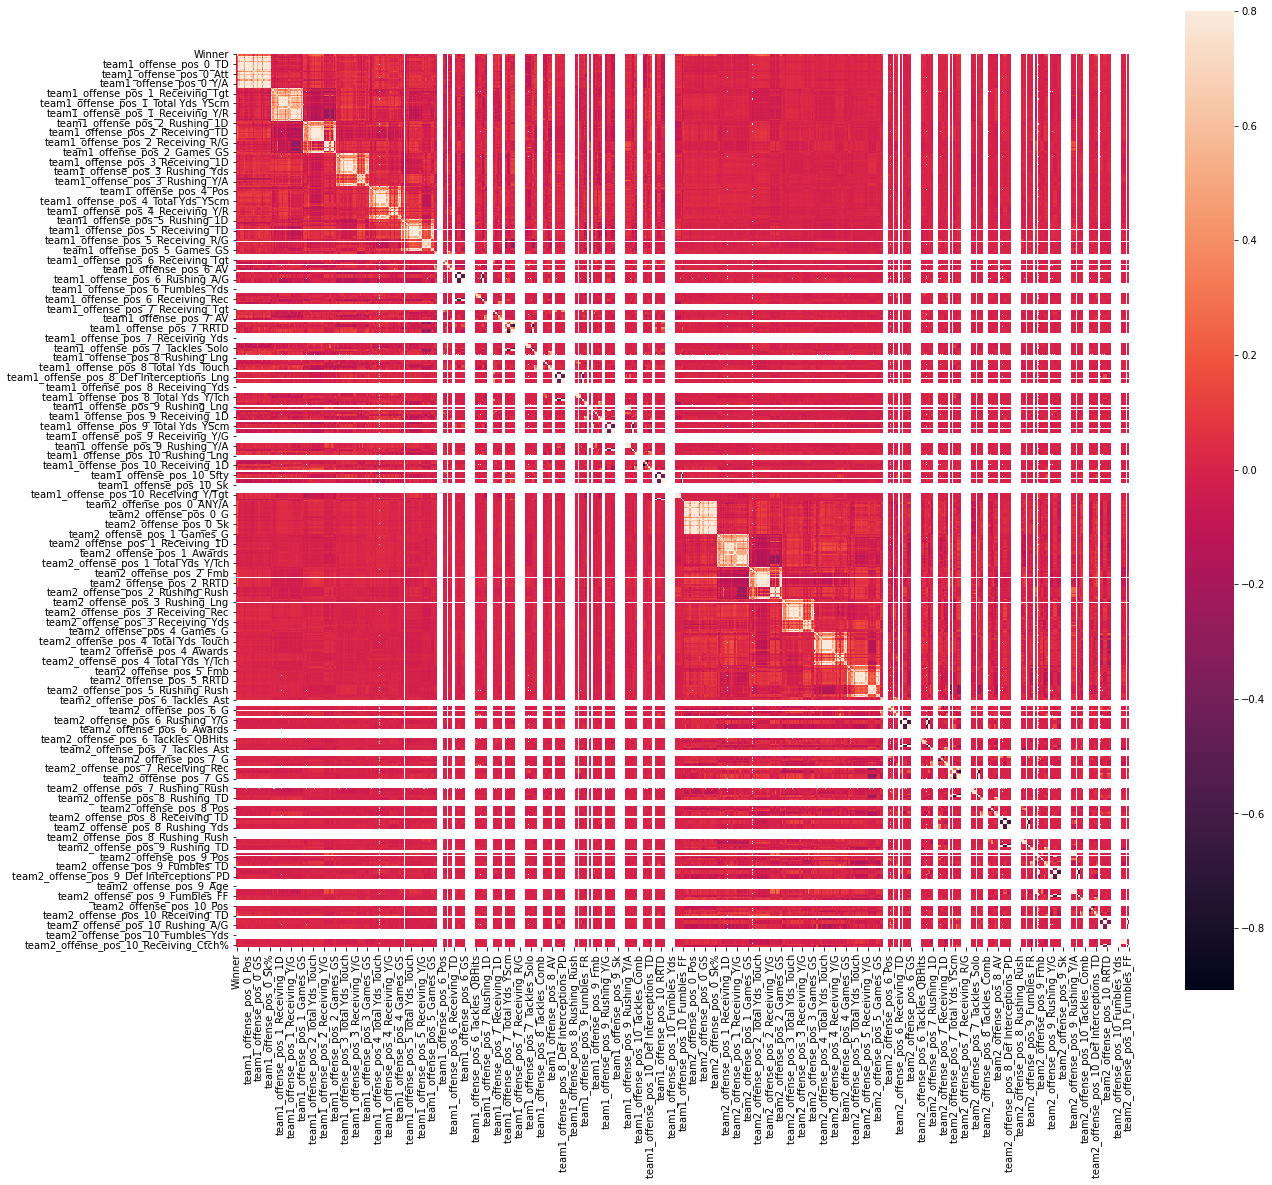

In [ ]:
#Offense matrix

corrmat = offenseDF.corr()
f, ax = plt.subplots(figsize=(20,18))
sns.heatmap(corrmat, vmax=.8, square=True)

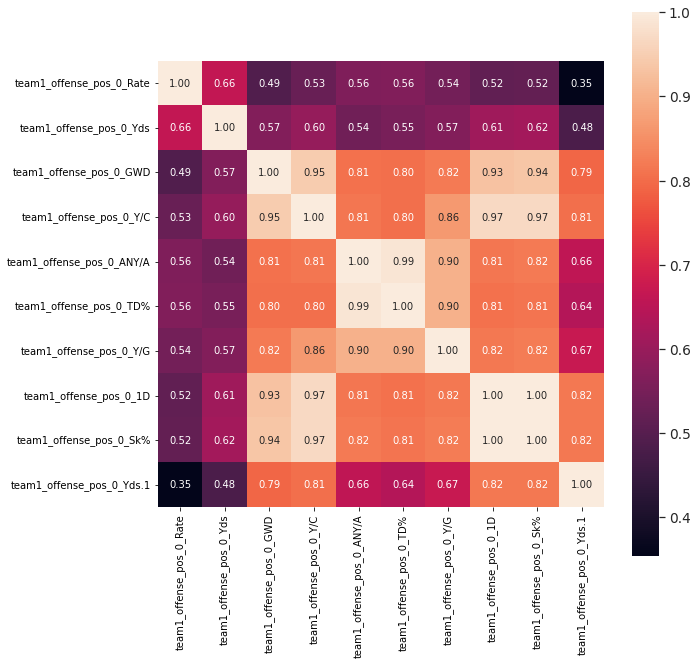

In [ ]:
#Offense Matrix

k = 10
cols = corrmat.nsmallest(k, 'Winner')['Winner'].index
f, ax = plt.subplots(figsize=(k,k))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

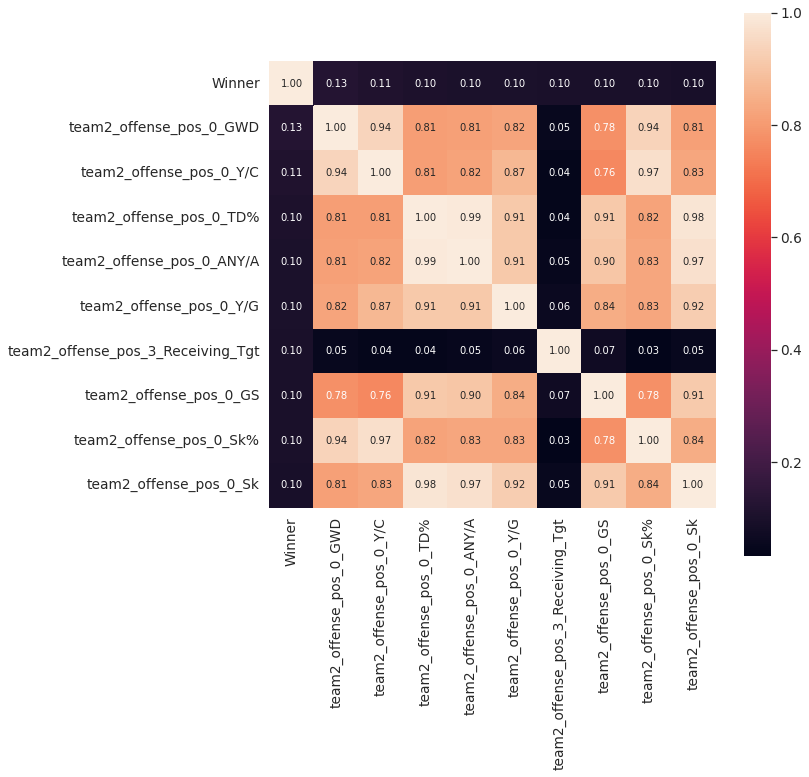

In [ ]:
#Offense Matrix

k = 10
cols = corrmat.nlargest(k, 'Winner')['Winner'].index
f, ax = plt.subplots(figsize=(k,k))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

##Defence Matrix

In [ ]:
defenceKeys = ["Winner"]
for key in df.keys():
  if "defence" in key:
    defenceKeys.append(key)

defenceDF = df.filter(defenceKeys, axis=1)

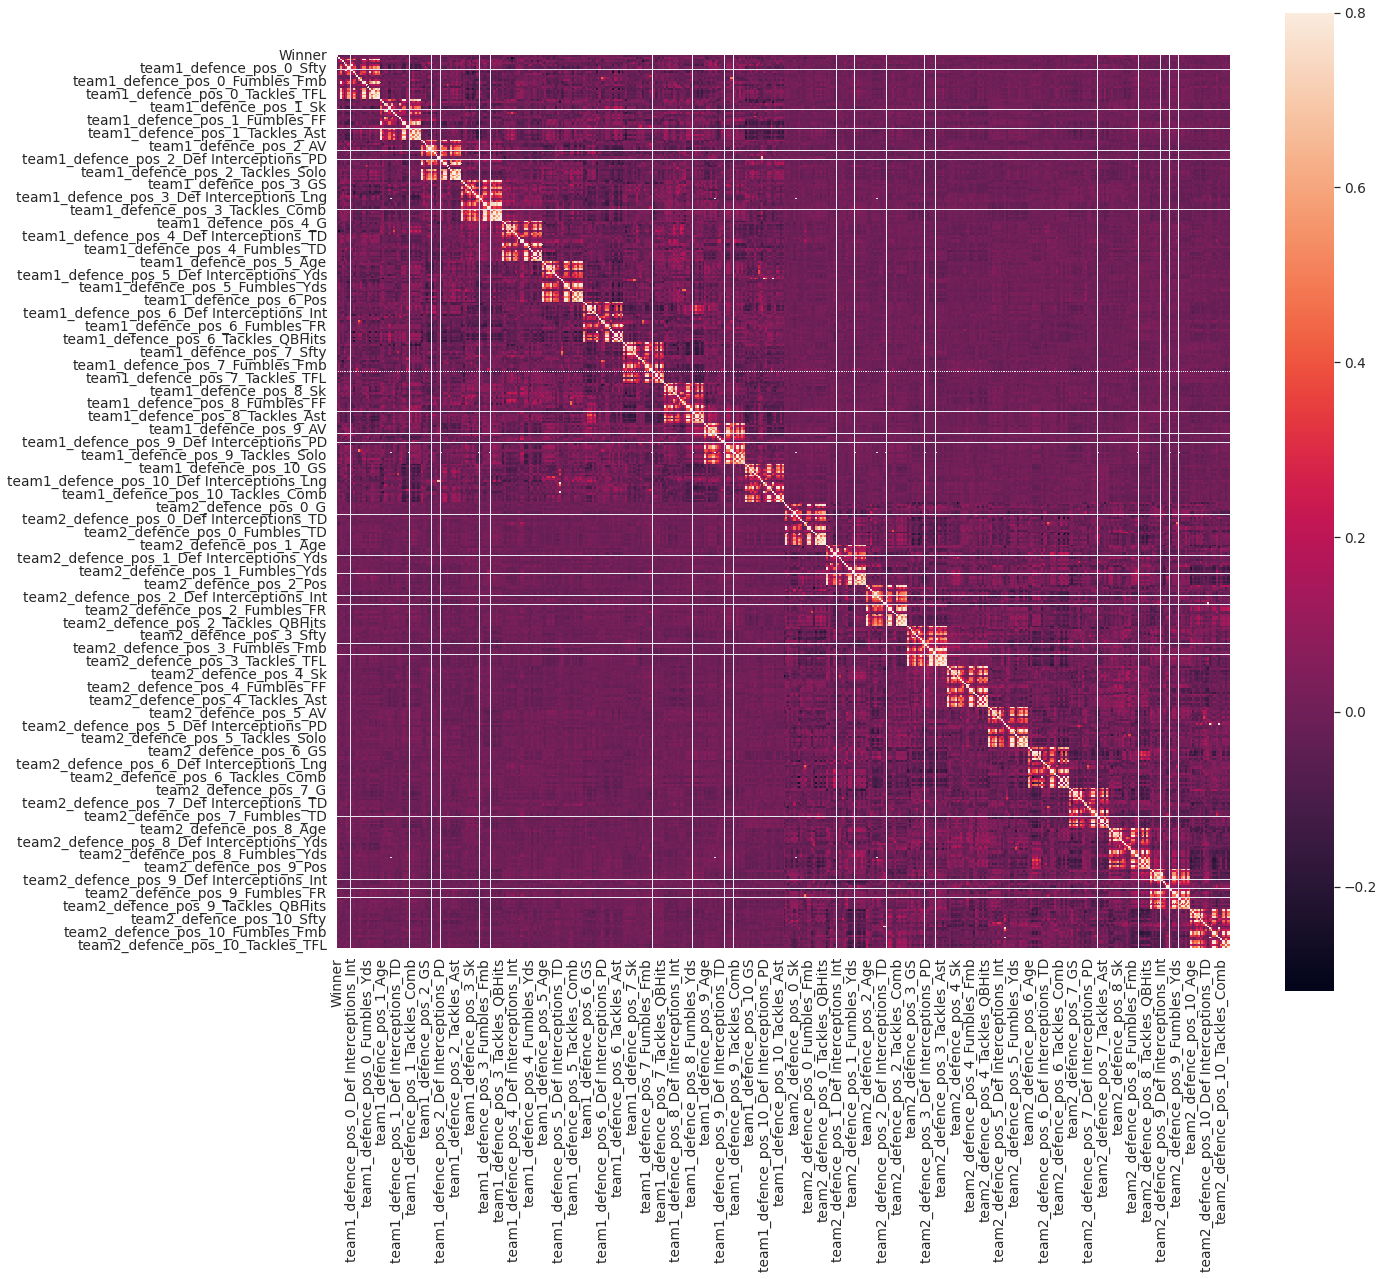

In [ ]:
#Defence matrix

corrmat = defenceDF.corr()
f, ax = plt.subplots(figsize=(20,18))
sns.heatmap(corrmat, vmax=.8, square=True)

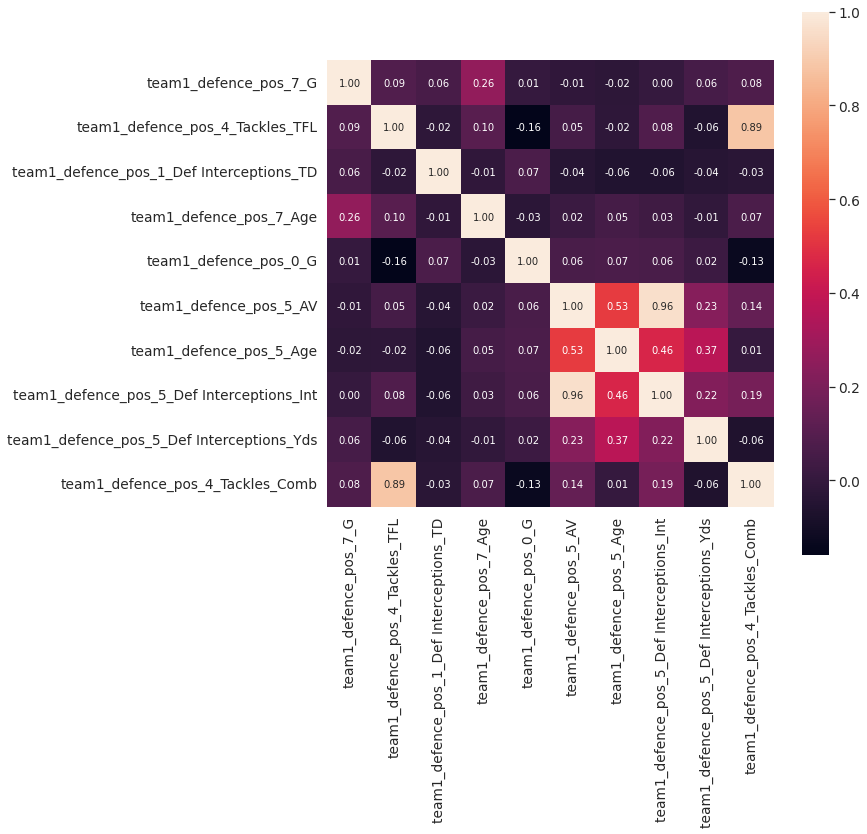

In [ ]:
k = 10
cols = corrmat.nsmallest(k, 'Winner')['Winner'].index
f, ax = plt.subplots(figsize=(k,k))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

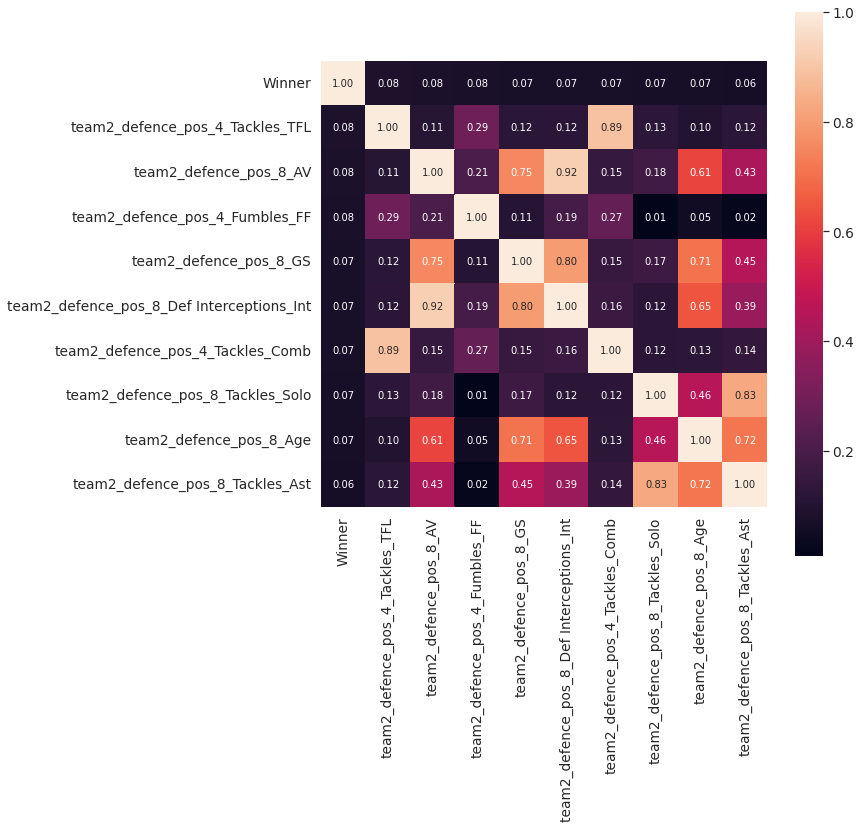

In [ ]:
#Defence Matrix

k = 10
cols = corrmat.nlargest(k, 'Winner')['Winner'].index
f, ax = plt.subplots(figsize=(k,k))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

##Finding the best collumns to use for classification
###This method of removing some collumns results in worse accuracy than other methods.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
def getCollumns(my_df):
  '''
  my_df - Dataframe
  Return - Dataframe
  Calculates a dataframe that only contains collumns that are correlated.
  '''
  X = my_df.drop(["Winner"], axis = 1)
  y = my_df["Winner"]

  feature_selector = SelectKBest(f_classif, k = "all")
  fit = feature_selector.fit(X,y)

  p_values = pd.DataFrame(fit.pvalues_)
  scores = pd.DataFrame(fit.scores_)
  input_variable_names = pd.DataFrame(X.columns)
  summary_stats = pd.concat([input_variable_names, p_values, scores], axis = 1)
  summary_stats.columns = ["input_variable", "p_value", "chi2_score"]
  summary_stats.sort_values(by = "p_value", inplace = True)

  p_value_threshold = 0.05
  score_threshold = 5

  selected_variables = summary_stats.loc[(summary_stats["chi2_score"] >= score_threshold) &
                                        (summary_stats["p_value"] <= p_value_threshold)]
  selected_variables = selected_variables["input_variable"].tolist()
  X_new = X[selected_variables]

  return X_new

In [ ]:
def getPosCollumns(my_df, pos, side):
  poscoll = ["Winner"]
  for key in my_df.keys():
    if "_"+str(pos)+"_" in key and 'team1_' in key and side in key:
      poscoll.append(key)
  return poscoll

In [ ]:
my_df = pd.read_csv('NFLdata.csv')
getPosCollumns(my_df, 0, 'offense')

['Winner',
 'team1_offense_pos_0_Cmp%',
 'team1_offense_pos_0_1D',
 'team1_offense_pos_0_Int%',
 'team1_offense_pos_0_ANY/A',
 'team1_offense_pos_0_GWD',
 'team1_offense_pos_0_TD%',
 'team1_offense_pos_0_Rate',
 'team1_offense_pos_0_4QC',
 'team1_offense_pos_0_TD',
 'team1_offense_pos_0_Pos',
 'team1_offense_pos_0_AY/A',
 'team1_offense_pos_0_Cmp',
 'team1_offense_pos_0_G',
 'team1_offense_pos_0_Yds.1',
 'team1_offense_pos_0_Int',
 'team1_offense_pos_0_AV',
 'team1_offense_pos_0_QBrec',
 'team1_offense_pos_0_Att',
 'team1_offense_pos_0_Yds',
 'team1_offense_pos_0_GS',
 'team1_offense_pos_0_Awards',
 'team1_offense_pos_0_Sk',
 'team1_offense_pos_0_QBR',
 'team1_offense_pos_0_Lng',
 'team1_offense_pos_0_Y/C',
 'team1_offense_pos_0_Y/G',
 'team1_offense_pos_0_Y/A',
 'team1_offense_pos_0_Age',
 'team1_offense_pos_0_NY/A',
 'team1_offense_pos_0_Sk%']

In [ ]:
my_df = pd.read_csv('NFLdata.csv')
offenseCol = getPosCollumns(my_df, 1, 'offense')
offenseCol.remove('Winner')
temp = []
for col in offenseCol:
  temp.append(col.replace('team1', 'team2'))

temp.extend(offenseCol)

temp2 = []
for col in temp:
  for x in range(1, 11):
    tempCol = col.split("_")
    tempCol[3] = str(x)
    temp2.append("_".join(tempCol))

offenseCol = getPosCollumns(my_df, 0, 'offense')
offenseCol.remove('Winner')
temp2.extend(offenseCol)
offenseCol = temp2.copy()

In [ ]:
offenseCol

['team2_offense_pos_1_Games_G',
 'team2_offense_pos_2_Games_G',
 'team2_offense_pos_3_Games_G',
 'team2_offense_pos_4_Games_G',
 'team2_offense_pos_5_Games_G',
 'team2_offense_pos_6_Games_G',
 'team2_offense_pos_7_Games_G',
 'team2_offense_pos_8_Games_G',
 'team2_offense_pos_9_Games_G',
 'team2_offense_pos_10_Games_G',
 'team2_offense_pos_1_Rushing_TD',
 'team2_offense_pos_2_Rushing_TD',
 'team2_offense_pos_3_Rushing_TD',
 'team2_offense_pos_4_Rushing_TD',
 'team2_offense_pos_5_Rushing_TD',
 'team2_offense_pos_6_Rushing_TD',
 'team2_offense_pos_7_Rushing_TD',
 'team2_offense_pos_8_Rushing_TD',
 'team2_offense_pos_9_Rushing_TD',
 'team2_offense_pos_10_Rushing_TD',
 'team2_offense_pos_1_Receiving_Ctch%',
 'team2_offense_pos_2_Receiving_Ctch%',
 'team2_offense_pos_3_Receiving_Ctch%',
 'team2_offense_pos_4_Receiving_Ctch%',
 'team2_offense_pos_5_Receiving_Ctch%',
 'team2_offense_pos_6_Receiving_Ctch%',
 'team2_offense_pos_7_Receiving_Ctch%',
 'team2_offense_pos_8_Receiving_Ctch%',
 'team2_

In [ ]:
my_df = pd.read_csv('NFLdata.csv')
offenseCol = ["Winner"]

for x in range(0, 11):
  tempDF = my_df.filter(getPosCollumns(my_df, x, 'offense'), axis=1)
  offenseCol.extend(list(getCollumns(tempDF).keys()))

offenseCol.remove('Winner')
temp = offenseCol.copy()
for col in offenseCol[1:]:
  temp.append(col.replace('team1', 'team2'))

offenseCol = temp
print(len(offenseCol))
offenseCol

127


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 8 20] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 3 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 3 10] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/

['team1_offense_pos_0_Rate',
 'team1_offense_pos_0_Yds',
 'team1_offense_pos_0_GWD',
 'team1_offense_pos_0_Y/C',
 'team1_offense_pos_0_ANY/A',
 'team1_offense_pos_0_TD%',
 'team1_offense_pos_0_Y/G',
 'team1_offense_pos_0_1D',
 'team1_offense_pos_0_Sk%',
 'team1_offense_pos_0_Yds.1',
 'team1_offense_pos_0_Cmp',
 'team1_offense_pos_0_Sk',
 'team1_offense_pos_0_G',
 'team1_offense_pos_0_Pos',
 'team1_offense_pos_0_Att',
 'team1_offense_pos_0_Y/A',
 'team1_offense_pos_0_4QC',
 'team1_offense_pos_0_NY/A',
 'team1_offense_pos_0_QBrec',
 'team1_offense_pos_0_GS',
 'team1_offense_pos_0_AY/A',
 'team1_offense_pos_0_Int%',
 'team1_offense_pos_0_Age',
 'team1_offense_pos_0_QBR',
 'team1_offense_pos_0_Int',
 'team1_offense_pos_1_Games_G',
 'team1_offense_pos_1_Rushing_Y/A',
 'team1_offense_pos_2_Rushing_1D',
 'team1_offense_pos_3_Receiving_Tgt',
 'team1_offense_pos_4_Rushing_Y/A',
 'team1_offense_pos_4_Total Yds_Y/Tch',
 'team1_offense_pos_4_Receiving_Y/R',
 'team1_offense_pos_4_Receiving_R/G',
 '

In [ ]:
my_df = pd.read_csv('NFLdata.csv')
defenceCol = ["Winner"]

for x in range(0, 11):
  tempDF = my_df.filter(getPosCollumns(my_df, x, 'defence'), axis=1)
  defenceCol.extend(list(getCollumns(tempDF).keys()))

defenceCol.remove('Winner')
temp = defenceCol.copy()
for col in defenceCol:
  temp.append(col.replace('team1', 'team2'))

defenceCol = temp

defenceCol

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [6] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 6 16] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 6 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/

['team1_defence_pos_0_G',
 'team1_defence_pos_0_Def Interceptions_Int',
 'team1_defence_pos_0_AV',
 'team1_defence_pos_0_Fumbles_TD',
 'team1_defence_pos_1_Def Interceptions_TD',
 'team1_defence_pos_1_G',
 'team1_defence_pos_1_Def Interceptions_PD',
 'team1_defence_pos_1_Fumbles_Yds',
 'team1_defence_pos_3_Fumbles_Yds',
 'team1_defence_pos_3_Def Interceptions_Int',
 'team1_defence_pos_3_Tackles_Comb',
 'team1_defence_pos_3_AV',
 'team1_defence_pos_3_Age',
 'team1_defence_pos_4_Tackles_TFL',
 'team1_defence_pos_4_Tackles_Comb',
 'team1_defence_pos_4_Sfty',
 'team1_defence_pos_4_Def Interceptions_Int',
 'team1_defence_pos_4_AV',
 'team1_defence_pos_5_AV',
 'team1_defence_pos_5_Age',
 'team1_defence_pos_5_Def Interceptions_Int',
 'team1_defence_pos_5_Def Interceptions_Yds',
 'team1_defence_pos_5_Tackles_Comb',
 'team1_defence_pos_5_Tackles_TFL',
 'team1_defence_pos_5_Tackles_Solo',
 'team1_defence_pos_5_Tackles_Ast',
 'team1_defence_pos_5_Sk',
 'team1_defence_pos_7_G',
 'team1_defence_pos

In [ ]:
allCollumns = ['Winner']
allCollumns.extend(offenseCol)
allCollumns.extend(defenceCol)
allCollumns

['Winner',
 'team1_offense_pos_0_Rate',
 'team1_offense_pos_0_Yds',
 'team1_offense_pos_0_GWD',
 'team1_offense_pos_0_Y/C',
 'team1_offense_pos_0_ANY/A',
 'team1_offense_pos_0_TD%',
 'team1_offense_pos_0_Y/G',
 'team1_offense_pos_0_1D',
 'team1_offense_pos_0_Sk%',
 'team1_offense_pos_0_Yds.1',
 'team1_offense_pos_0_Cmp',
 'team1_offense_pos_0_Sk',
 'team1_offense_pos_0_G',
 'team1_offense_pos_0_Pos',
 'team1_offense_pos_0_Att',
 'team1_offense_pos_0_Y/A',
 'team1_offense_pos_0_4QC',
 'team1_offense_pos_0_NY/A',
 'team1_offense_pos_0_QBrec',
 'team1_offense_pos_0_GS',
 'team1_offense_pos_0_AY/A',
 'team1_offense_pos_0_Int%',
 'team1_offense_pos_0_Age',
 'team1_offense_pos_0_QBR',
 'team1_offense_pos_0_Int',
 'team1_offense_pos_1_Games_G',
 'team1_offense_pos_1_Rushing_Y/A',
 'team1_offense_pos_2_Rushing_1D',
 'team1_offense_pos_3_Receiving_Tgt',
 'team1_offense_pos_4_Rushing_Y/A',
 'team1_offense_pos_4_Total Yds_Y/Tch',
 'team1_offense_pos_4_Receiving_Y/R',
 'team1_offense_pos_4_Receivi

# Setup Data

allCollumns is the collumns we want to use for our model training.

In [284]:
df = pd.read_csv('NFLdata.csv')
newDF = df.filter(items=allCollumns)
newDF

,Winner,Year,team1_offense_pos_0_Sk,team2_offense_pos_0_Sk,team1_offense_pos_0_Rate,team2_offense_pos_0_Rate,team1_offense_pos_0_Y/C,team2_offense_pos_0_Y/C,team1_offense_pos_0_Y/G,team2_offense_pos_0_Y/G,team1_offense_pos_0_Sk%,team2_offense_pos_0_Sk%,team1_offense_pos_0_Cmp,team2_offense_pos_0_Cmp,team1_offense_pos_0_Pos,team2_offense_pos_0_Pos,team1_offense_pos_0_AV,team2_offense_pos_0_AV,team1_offense_pos_0_QBrec,team2_offense_pos_0_QBrec,team1_offense_pos_0_Cmp%,team2_offense_pos_0_Cmp%,team1_offense_pos_0_TD%,team2_offense_pos_0_TD%,team1_offense_pos_0_4QC,team2_offense_pos_0_4QC,team1_offense_pos_0_Age,team2_offense_pos_0_Age,team1_offense_pos_0_Awards,team2_offense_pos_0_Awards,team1_offense_pos_0_1D,team2_offense_pos_0_1D,team1_offense_pos_0_Yds.1,team2_offense_pos_0_Yds.1,team1_offense_pos_0_AY/A,team2_offense_pos_0_AY/A,team1_offense_pos_0_NY/A,team2_offense_pos_0_NY/A,team1_offense_pos_0_GWD,team2_offense_pos_0_GWD,...,team1_defence_pos_10_G,team2_defence_pos_10_G,team1_defence_pos_10_GS,team2_defence_pos_10_GS,team1_defence_pos_10_AV,team2_defence_pos_10_AV,team1_defence_pos_10_Sk,team2_defence_pos_10_Sk,team1_defence_pos_10_Sfty,team2_defence_pos_10_Sfty,team1_defence_pos_10_Def Interceptions_Int,team2_defence_pos_10_Def Interceptions_Int,team1_defence_pos_10_Def Interceptions_Yds,team2_defence_pos_10_Def Interceptions_Yds,team1_defence_pos_10_Def Interceptions_TD,team2_defence_pos_10_Def Interceptions_TD,team1_defence_pos_10_Def Interceptions_Lng,team2_defence_pos_10_Def Interceptions_Lng,team1_defence_pos_10_Def Interceptions_PD,team2_defence_pos_10_Def Interceptions_PD,team1_defence_pos_10_Fumbles_FF,team2_defence_pos_10_Fumbles_FF,team1_defence_pos_10_Fumbles_Fmb,team2_defence_pos_10_Fumbles_Fmb,team1_defence_pos_10_Fumbles_FR,team2_defence_pos_10_Fumbles_FR,team1_defence_pos_10_Fumbles_Yds,team2_defence_pos_10_Fumbles_Yds,team1_defence_pos_10_Fumbles_TD,team2_defence_pos_10_Fumbles_TD,team1_defence_pos_10_Tackles_Comb,team2_defence_pos_10_Tackles_Comb,team1_defence_pos_10_Tackles_Solo,team2_defence_pos_10_Tackles_Solo,team1_defence_pos_10_Tackles_Ast,team2_defence_pos_10_Tackles_Ast,team1_defence_pos_10_Tackles_TFL,team2_defence_pos_10_Tackles_TFL,team1_defence_pos_10_Tackles_QBHits,team2_defence_pos_10_Tackles_QBHits
0,0,2010,3.17,3.50,5.42,4.30,158.00,154.50,40.33,18.00,12.17,12.00,266.83,98.00,63.43,59.70,21.17,19.00,6.39,6.30,401.83,442.50,8.12,7.20,7.70,6.75,12.75,12.05,0,0,220.88,211.65,14.50,15.00,69.67,80.00,13.50,12.50,3.38,2.80,...,1.0,1.50,0.0,7.50,3.62,3.50,0,0,1.12,12.50,0.00,1.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,9.38,8.0,9.38,8.0,32,32,0,0,0.0,1.0,15.12,6.00,55.12,37.00,0.0,1.50,40.00,31.00,0.00,1.50
1,1,2010,0.00,1.50,1.84,1.35,40.80,79.50,13.60,13.00,1.60,4.00,73.80,88.00,34.32,59.55,4.20,6.00,2.16,5.21,146.80,231.50,3.44,6.00,2.66,5.55,6.00,10.05,0,0,96.60,113.95,5.80,8.50,46.60,43.00,5.40,7.00,2.54,1.55,...,9.0,0.00,37.0,0.00,11.00,0.00,0,0,118.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,11.00,2.0,11.00,2.0,32,0,0,0,0.0,0.0,12.00,3.00,45.00,14.00,0.0,0.00,33.00,11.00,0.00,0.00
2,0,2010,2.75,1.00,4.97,3.50,153.75,39.75,21.50,11.75,10.00,2.75,127.75,71.50,61.38,46.82,20.25,5.75,5.88,4.21,443.75,130.50,7.18,4.88,6.58,4.97,11.72,7.85,0,0,232.70,137.88,13.25,4.75,75.75,33.75,15.75,2.75,3.55,1.35,...,2.0,2.00,21.8,101.00,5.40,8.00,0,1,22.40,130.00,2.40,0.0,1.4,1.0,0.0,0.0,0,1,10.8,65.0,12.80,15.0,12.80,15.0,31,32,0,1,0.0,1.0,12.20,29.00,67.60,94.00,0.0,3.00,55.40,65.00,2.00,7.00
3,0,2010,2.30,2.67,4.27,4.53,152.30,158.50,21.90,22.33,12.10,10.67,136.40,152.50,60.33,62.42,22.50,21.33,6.19,5.76,421.80,438.50,6.75,6.92,6.70,6.43,10.94,11.07,0,0,201.67,224.87,12.90,13.50,58.70,66.50,9.90,13.33,1.91,3.08,...,3.0,1.22,25.0,17.11,7.00,4.89,0,0,58.00,22.78,1.67,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,9.00,9.0,9.00,9.0,31,32,0,0,0.0,1.0,20.33,9.89,65.00,46.44,0.0,1.56,44.67,36.56,3.33,2.67
4,1,2010,0.00,2.00,0.00,3.40,0.00,90.00,0.00,20.00,0.00,2.00,0.00,102.00,0.00,54.50,0.00,10.00,0.00,3.69,0.00,290.00,0.00,6.40,0.00

In [285]:
tempDf = newDF.values.tolist()
tempDf[0]

[0.0,
 2010.0,
 3.17,
 3.5,
 5.42,
 4.3,
 158.0,
 154.5,
 40.33,
 18.0,
 12.17,
 12.0,
 266.83,
 98.0,
 63.43,
 59.7,
 21.17,
 19.0,
 6.39,
 6.3,
 401.83,
 442.5,
 8.12,
 7.2,
 7.7,
 6.75,
 12.75,
 12.05,
 0.0,
 0.0,
 220.88,
 211.65,
 14.5,
 15.0,
 69.67,
 80.0,
 13.5,
 12.5,
 3.38,
 2.8,
 9.05,
 3.9,
 6.78,
 6.71,
 40.77,
 68.25,
 0.0,
 0.0,
 3217.0,
 3178.0,
 27.0,
 24.0,
 2.5,
 1.5,
 254.33,
 264.0,
 92.8,
 84.3,
 14.33,
 15.0,
 1.0,
 1.0,
 6.95,
 4.87,
 9.45,
 5.92,
 10.3,
 1.83,
 130.5,
 130.33,
 6.5,
 4.67,
 22.0,
 27.0,
 9.95,
 9.22,
 4.35,
 5.2,
 722.0,
 662.33,
 144.0,
 134.0,
 1.05,
 0.0,
 0.0,
 0.0,
 4.0,
 5.5,
 583.0,
 637.83,
 10.0,
 14.33,
 3.85,
 5.22,
 41.9,
 45.35,
 18.5,
 12.83,
 5.5,
 5.5,
 7.0,
 1.17,
 3.0,
 3.0,
 139.0,
 24.5,
 17.5,
 5.33,
 3.5,
 5.5,
 1.5,
 1.5,
 26.5,
 30.0,
 0.0,
 0.0,
 36.0,
 64.67,
 0.0,
 0.0,
 13.5,
 3.67,
 10.5,
 6.92,
 19.4,
 13.42,
 47.3,
 32.9,
 5.0,
 0.0,
 4.0,
 9.17,
 23.0,
 27.0,
 0.0,
 0.0,
 18.3,
 13.07,
 44.0,
 39.5,
 804.0,
 501.

In [ ]:
def useMeanValues(dataList):
  '''
  dataList - 2D array
  Return - 2D array
  The returned array has the averages on any data that is 0
  '''
  values = []
  for data in dataList[0]:
    values.append([])
  for x in range(0, len(dataList)):
    for z in range(0, len(dataList[x])):
      if(int(dataList[x][z]) != 0):
        values[z].append(dataList[x][z])

  for x in range(0, len(values)):
    if values[x] == []:
      values[x] = [0]
  
  for x in range(0, len(dataList)):
    for z in range(0, len(dataList[x])):
      if int(dataList[x][z]) == 0 and int(statistics.mean(values[z])) != 1 and int(statistics.mean(values[z])) != 0:
        dataList[x][z] = statistics.mean(values[z])
  
  return dataList

In [ ]:
#This does not increase accuracy with the tests I used.
#tempDf = useMeanValues(tempDf)

In [286]:
def getYearData(twoDList):
  '''
  twoDList - 2D List
  Return - list, list, list, list, list, list
  This calculates the validation, training, and test data from the twoDList provided.
  '''
  xData = []
  yData = []
  for row in tempDf:
    xData.append(list(map(float, row[1:])))
    yData.append(float(row[0]))

  x_train = []
  y_train = []
  x_validation = []
  y_validation = []
  x_test = []
  y_test = []
  for x in range(0, len(xData)):
    if int(xData[x][0]) <= 2019:
      x_train.append(xData[x][1:])
      y_train.append(yData[x])
    elif int(xData[x][0]) == 2020:
      x_test.append(xData[x][1:])
      y_test.append(yData[x])
    '''elif int(xData[x][0]) == 2019:
      x_validation.append(xData[x][1:])
      y_validation.append(yData[x])'''

  x_train, y_train, x_test, y_test = tf.constant(x_train), tf.constant(y_train), tf.constant(x_test), tf.constant(y_test)
  x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

  x_validation, y_validation = tf.constant(x_validation), tf.constant(y_validation)
  x_validation, y_validation = np.array(x_validation), np.array(y_validation)
  return x_train, y_train, x_validation, y_validation, x_test, y_test

In [287]:
x_train, y_train, x_validation, y_validation, x_test, y_test = getYearData(tempDf)

In [ ]:
#Removed validation data since the model already allocates 20 percent of the Train data for validation.

In [37]:
print(x_train.shape, y_train.shape)
print(x_validation.shape, y_validation.shape)
print(x_test.shape, y_test.shape)

(2446, 1304) (2446,)
(0,) (0,)
(252, 1304) (252,)


# Overfit Models
## This shows us how overfitting is happening.

In [ ]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [ ]:
def compile_and_fit(model, name, xtrain, ytrain, optimizer=None, validation=0.2, max_epochs=10000):
  if optimizer == None:
    optimizer = tf.keras.optimizers.Adam()
  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['binary_crossentropy', 'accuracy'])

  model.summary()

  history = model.fit(
    x = xtrain,
    y = ytrain,
    epochs=max_epochs,
    validation_split=validation,
    callbacks=get_callbacks(name),
    verbose=0)
  return history, model

In [ ]:
tiny_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(x_test.shape[1:])),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
size_histories = {}

In [ ]:
size_histories['Tiny'], tiny_model = compile_and_fit(tiny_model, 'sizes/Tiny', x_train, y_train)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                83520     
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 83,585
Trainable params: 83,585
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5102,  binary_crossentropy:13.3414,  loss:13.3414,  val_accuracy:0.5102,  val_binary_crossentropy:5.3341,  val_loss:5.3341,  
........

KeyboardInterrupt: ignored

In [ ]:
#As you see the accuracy is extremely HIGH but the validation accuracy is extremely LOW

(0.0, 10.0)

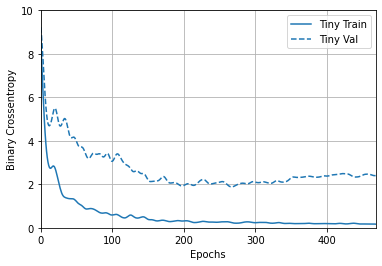

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 10])

In [ ]:
eval_result = tiny_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 2ms/step - loss: 3.0819 - binary_crossentropy: 3.0819 - accuracy: 0.5476
[test loss, test accuracy]: [3.081906795501709, 3.081906795501709, 0.5476190447807312]


In [ ]:
small_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(x_test.shape[1:])),
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
size_histories['Small'], small_model = compile_and_fit(small_model, 'sizes/Small', x_train, y_train)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 64)                83520     
                                                                 
 dense_27 (Dense)            (None, 64)                4160      
                                                                 
 dense_28 (Dense)            (None, 1)                 65        
                                                                 
Total params: 87,745
Trainable params: 87,745
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5061,  binary_crossentropy:5.2577,  loss:5.2577,  val_accuracy:0.5000,  val_binary_crossentropy:4.4115,  val_loss:4.4115,  
....................................................................................................
Epoch: 100, accuracy:0.8548,  binary_crossentropy:0.3204,  loss:0.3

(0.0, 10.0)

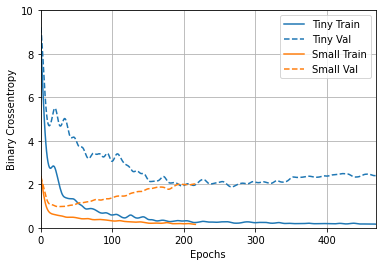

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 10])

In [ ]:
eval_result = small_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 2ms/step - loss: 2.4168 - binary_crossentropy: 2.4168 - accuracy: 0.5119
[test loss, test accuracy]: [2.4168343544006348, 2.4168343544006348, 0.511904776096344]


In [ ]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(x_test.shape[1:])),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
size_histories['Medium'], medium_model = compile_and_fit(medium_model, 'sizes/Medium', x_train, y_train)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 64)                83520     
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 1)                 65        
                                                                 
Total params: 91,905
Trainable params: 91,905
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5133,  binary_crossentropy:6.0201,  loss:6.0201,  val_accuracy:0.5041,  val_binary_crossentropy:1.6071,  val_loss:1.6071,  
...................................

(0.0, 10.0)

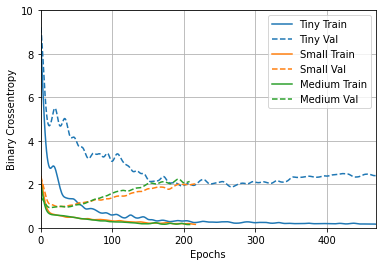

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 10])

In [ ]:
eval_result = medium_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 2ms/step - loss: 2.4023 - binary_crossentropy: 2.4023 - accuracy: 0.5357
[test loss, test accuracy]: [2.402332067489624, 2.402332067489624, 0.5357142686843872]


In [ ]:
large_model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(x_test.shape[1:])),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
size_histories['Large'], large_model = compile_and_fit(large_model, 'sizes/Large', x_train, y_train)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 64)                83520     
                                                                 
 dense_34 (Dense)            (None, 64)                4160      
                                                                 
 dense_35 (Dense)            (None, 64)                4160      
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 96,065
Trainable params: 96,065
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5343,  binary_crossentropy:

(0.0, 10.0)

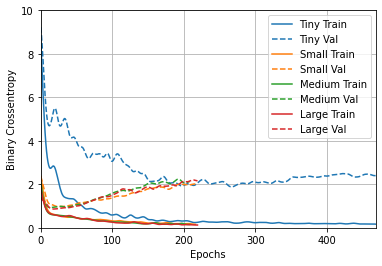

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0, 10])

In [ ]:
eval_result = large_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 2ms/step - loss: 2.8570 - binary_crossentropy: 2.8570 - accuracy: 0.5675
[test loss, test accuracy]: [2.8569955825805664, 2.8569955825805664, 0.567460298538208]


# Methods for Overfit Models

In [ ]:
regularizer_histories = {}

In [ ]:
l2_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(x_test.shape[1:])),
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['l2_model'], l2_model = compile_and_fit(l2_model, "regularizers/l2_model", x_train, y_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                83520     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 87,745
Trainable params: 87,745
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5102,  binary_crossentropy:9.7837,  loss:9.8737,  val_accuracy:0.4898,  val_binary_crossentropy:2.9215,  val_loss:2.9984,  
...........

KeyboardInterrupt: ignored

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0, 5])

In [ ]:
eval_result = l2_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
dropout_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(x_test.shape[1:])),
    layers.Dropout(0.1),
    layers.Dense(64, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

regularizer_histories['dropout'], dropout_model = compile_and_fit(dropout_model, "regularizers/dropout", x_train, y_train)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 64)                83520     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_69 (Dense)            (None, 64)                4160      
                                                                 
 dense_70 (Dense)            (None, 1)                 65        
                                                                 
Total params: 87,745
Trainable params: 87,745
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5066,  binary_crossentropy:11.0863,  loss:11.0863,  val_accuracy:0.5531,  val_binary_crossentropy:3.2098,  val_loss:3.2098,  
.................................

(0.0, 5.0)

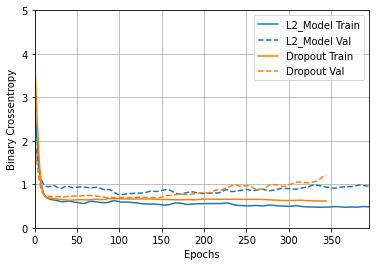

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0, 5])

In [ ]:
eval_result = dropout_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 3ms/step - loss: 1.1720 - binary_crossentropy: 1.1720 - accuracy: 0.5595
[test loss, test accuracy]: [1.1719719171524048, 1.1719719171524048, 0.5595238208770752]


In [ ]:
combined_model = tf.keras.Sequential([
    layers.Dense(64, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(x_test.shape[1:])),
    layers.Dropout(0.01),
    layers.Dense(64,
                 activation='elu'),
    layers.Dense(1, activation='sigmoid')
])
regularizer_histories['combined'], combined_model = compile_and_fit(combined_model, "regularizers/combined", x_train, y_train)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 64)                83520     
                                                                 
 dropout_10 (Dropout)        (None, 64)                0         
                                                                 
 dense_75 (Dense)            (None, 64)                4160      
                                                                 
 dense_76 (Dense)            (None, 1)                 65        
                                                                 
Total params: 87,745
Trainable params: 87,745
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5031,  binary_crossentropy:13.3929,  loss:13.4020,  val_accuracy:0.5122,  val_binary_crossentropy:5.2450,  val_loss:5.2528,  
.................................

(0.0, 10.0)

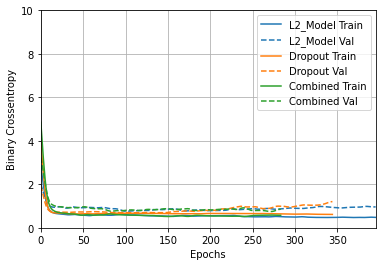

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0, 10])

In [ ]:
eval_result = combined_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 2ms/step - loss: 1.0805 - binary_crossentropy: 1.0715 - accuracy: 0.6190
[test loss, test accuracy]: [1.080511212348938, 1.0715266466140747, 0.6190476417541504]


# Tune Hyperparameters

In [ ]:
x_train.shape

(2446, 1304)

In [ ]:
x_train.shape[1:][0]

1304

In [ ]:
def model_builder(hp):
  model = keras.Sequential()

  maxVal = x_train.shape[1:][0]

  hp_units1 = hp.Int('units1', min_value=2, max_value=maxVal, step=1)
  DropOut_units1 = hp.Float('droprate1', min_value=.01, max_value=.5, step=.01)
  l2_units1 = hp.Float('l2rate1', min_value=.0001, max_value=.1, step=.0001)

  hp_units2 = hp.Int('units2', min_value=2, max_value=maxVal, step=1)
  DropOut_units2 = hp.Float('droprate2', min_value=.01, max_value=.5, step=.01)
  l2_units2 = hp.Float('l2rate2', min_value=.0001, max_value=.1, step=.0001)

  hp_units3 = hp.Int('units3', min_value=2, max_value=maxVal, step=1)
  DropOut_units3 = hp.Float('droprate3', min_value=.01, max_value=.5, step=.01)
  l2_units3 = hp.Float('l2rate3', min_value=.0001, max_value=.1, step=.0001)

  hp_units4 = hp.Int('units4', min_value=2, max_value=maxVal, step=1)
  DropOut_units4 = hp.Float('droprate4', min_value=.01, max_value=.5, step=.01)
  l2_units4 = hp.Float('l2rate4', min_value=.0001, max_value=.1, step=.0001)

  hp_units5 = hp.Int('units5', min_value=2, max_value=maxVal, step=1)

  model.add(keras.layers.Dense(units=hp_units1, kernel_regularizer=regularizers.l2(l2_units1),
                 activation='elu', input_shape=(x_test.shape[1:])))
  model.add(keras.layers.Dropout(DropOut_units1))
  model.add(keras.layers.Dense(units=hp_units2, kernel_regularizer=regularizers.l2(l2_units2), activation='elu'))
  model.add(keras.layers.Dropout(DropOut_units2))
  model.add(keras.layers.Dense(units=hp_units3, kernel_regularizer=regularizers.l2(l2_units2), activation='elu'))
  model.add(keras.layers.Dropout(DropOut_units3))
  model.add(keras.layers.Dense(units=hp_units4, kernel_regularizer=regularizers.l2(l2_units2), activation='elu'))
  model.add(keras.layers.Dropout(DropOut_units4))
  model.add(keras.layers.Dense(units=hp_units5, activation='elu'))
  model.add(keras.layers.Dense(1, activation = 'sigmoid'))

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
        tf.keras.losses.BinaryCrossentropy(),
        tf.keras.metrics.BinaryAccuracy(name='accuracy')
    ])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective("val_accuracy", direction="max"),
                     max_epochs=250,
                     factor=2,
                     overwrite=True,
                     directory='my_dir',
                     project_name='intro_to_kt100')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)

In [ ]:
tuner.search(x_train, y_train, epochs=250, validation_split=.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 321 Complete [00h 00m 02s]
val_accuracy: 0.5428571701049805

Best val_accuracy So Far: 0.5877550840377808
Total elapsed time: 00h 17m 09s

Search: Running Trial #322

Hyperparameter    |Value             |Best Value So Far 
units1            |977               |473               
droprate1         |0.06              |0.23              
l2rate1           |0.0814            |0.0206            
units2            |1103              |1112              
droprate2         |0.12              |0.06              
l2rate2           |0.0856            |0.0201            
units3            |962               |291               
tuner/epochs      |4                 |63                
tuner/initial_e...|0                 |32                
tuner/bracket     |6                 |7                 
tuner/round       |0                 |5                 

Epoch 1/4
56/62 [==========================>...] - ETA: 0s - loss: 137.2547 - binary_crossentropy: 32.0430 - accuracy: 0.5056

KeyboardInterrupt: ignored

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(x_train, y_train, epochs=250, validation_split=0.2)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x_train, y_train, epochs=best_epoch, validation_split=0.2)

In [ ]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
hypermodel.summary()

In [ ]:
print('completed')

In [ ]:
#The code below tries to find the best model and SAVE it for later use

In [ ]:
found = False
while(not found):
  model = tuner.hypermodel.build(best_hps)
  for z in range(1, 250):
    history = model.fit(x_train, y_train, epochs=1, validation_split=0.2)
    val_acc_per_epoch = history.history['val_accuracy']
    if val_acc_per_epoch[0] > .60:
      hypermodel = model
      found = True
      break

print("BESTMODEL:", max)

In [ ]:
eval_result = hypermodel.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

In [ ]:
print('completed')

# Training Best Model
## This is just to test some model designs for the best model

In [288]:
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [289]:
def compile_and_fit(model, name, xtrain, ytrain, optimizer=None, validation=0.2, max_epochs=10000):
  model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['binary_crossentropy', 'accuracy'])

  model.summary()

  history = model.fit(
    x = xtrain,
    y = ytrain,
    epochs=max_epochs,
    validation_split=validation,
    callbacks=get_callbacks(name),
    verbose=0)
  return history, model

In [290]:
best_histories = {}

In [361]:
made_model = tf.keras.Sequential([
    layers.Dense(411,
                 activation='elu', input_shape=(x_test.shape[1:]), kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),
    layers.Dense(86, kernel_regularizer=regularizers.l2(0.01),
                 activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(227, kernel_regularizer=regularizers.l2(0.01),
                 activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(435, kernel_regularizer=regularizers.l2(0.01),
                 activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(1030, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])
best_histories['made_model'], made_model = compile_and_fit(made_model, "made_model", x_train, y_train)

..................................................................................................
Epoch: 100, accuracy:0.5736,  binary_crossentropy:0.6846,  loss:0.6985,  val_accuracy:0.5388,  val_binary_crossentropy:0.6895,  val_loss:0.7013,  
....................................................................................................
Epoch: 200, accuracy:0.6104,  binary_crossentropy:0.6574,  loss:0.6834,  val_accuracy:0.5653,  val_binary_crossentropy:0.6804,  val_loss:0.7049,  
....................................................................................................
Epoch: 300, accuracy:0.6089,  binary_crossentropy:0.6480,  loss:0.6805,  val_accuracy:0.5612,  val_binary_crossentropy:0.7060,  val_loss:0.7426,  
....................................................................................................
Epoch: 400, accuracy:0.6104,  binary_crossentropy:0.6370,  loss:0.6719,  val_accuracy:0.5714,  val_binary_crossentropy:0.7202,  val_loss:0.7585,  
..........

(0.0, 2.0)

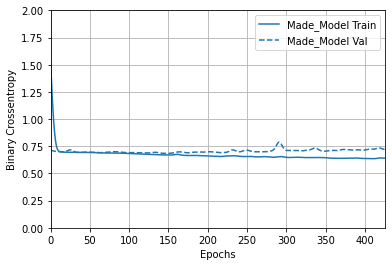

In [362]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(best_histories)
plt.ylim([0, 2])

(0.0, 1.0)

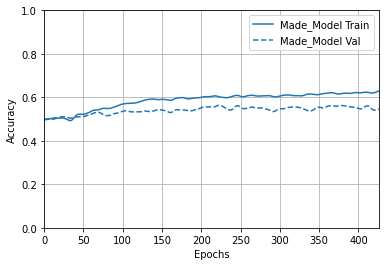

In [363]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(best_histories)
plt.ylim([0, 1])

In [365]:
eval_result = made_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 2ms/step - loss: 0.8211 - binary_crossentropy: 0.7847 - accuracy: 0.4484
[test loss, test accuracy]: [0.8211060762405396, 0.7847223877906799, 0.44841268658638]


In [460]:
made_model = tf.keras.Sequential([
    layers.Dense(411,
                 activation='elu', input_shape=(x_test.shape[1:]), kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.1),
    layers.Dense(86, kernel_regularizer=regularizers.l2(0.01),
                 activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(227, kernel_regularizer=regularizers.l2(0.01),
                 activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(435, kernel_regularizer=regularizers.l2(0.01),
                 activation='elu'),
    layers.Dropout(0.1),
    layers.Dense(1030, activation='elu'),
    layers.Dense(1, activation='sigmoid')
])

In [461]:
made_model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='binary_crossentropy',
                metrics=['binary_crossentropy', 'accuracy'])

In [462]:
made_model.fit(x_train, y_train, validation_split=.1, epochs=100)

Epoch 1/100
69/69 [==============================] - 1s 6ms/step - loss: 12.3735 - binary_crossentropy: 3.7675 - accuracy: 0.5002 - val_loss: 7.6774 - val_binary_crossentropy: 0.7298 - val_accuracy: 0.5102
Epoch 2/100
69/69 [==============================] - 0s 4ms/step - loss: 7.0169 - binary_crossentropy: 0.7352 - accuracy: 0.4916 - val_loss: 6.4084 - val_binary_crossentropy: 0.7185 - val_accuracy: 0.4776
Epoch 3/100
69/69 [==============================] - 0s 4ms/step - loss: 5.9405 - binary_crossentropy: 0.7051 - accuracy: 0.4911 - val_loss: 5.5039 - val_binary_crossentropy: 0.6958 - val_accuracy: 0.4776
Epoch 4/100
69/69 [==============================] - 0s 4ms/step - loss: 5.1577 - binary_crossentropy: 0.6978 - accuracy: 0.5329 - val_loss: 4.8204 - val_binary_crossentropy: 0.6938 - val_accuracy: 0.4816
Epoch 5/100
69/69 [==============================] - 0s 4ms/step - loss: 4.5655 - binary_crossentropy: 0.7157 - accuracy: 0.5093 - val_loss: 4.2911 - val_binary_crossentropy: 0.70

In [463]:
eval_result = made_model.evaluate(x_test, y_test)
print("[test loss, test accuracy]:", eval_result)

8/8 [==============================] - 0s 3ms/step - loss: 0.6926 - binary_crossentropy: 0.6755 - accuracy: 0.6151
[test loss, test accuracy]: [0.6926088333129883, 0.6755496859550476, 0.6150793433189392]


# Predict Future Games
## This code is outdated from main code but can be used in the future.

In [ ]:
def getFutureGame(year, week):
  url = 'https://www.pro-football-reference.com/years/' + str(year) + '/games.htm'
  maxgames = 1000
      
  # grab data
  r = requests.get(url)
  soup = str(BeautifulSoup(r.content, 'html.parser'))

  games = []

  start = soup.find("csk=\"" + str(week) + "\"")
  while(soup[start: start+500] != ""):
    snippit = soup[start: start+500]
    location = snippit.find("href=\"/teams/")
    team1 = snippit[location+13:location+16]
    snippit = snippit[location+16:]
    location = snippit.find("href=\"/teams/")
    team2 = snippit[location+13:location+16]
    games.append({'Winner': team1, 'Loser': team2})

    soup = soup[start+500:-1]
    start = soup.find("csk=\"" + str(week) + "\"")
  return games

In [ ]:
games = getFutureGame(2021, 16)
games

[{'Loser': 'sfo', 'Winner': 'oti'},
 {'Loser': 'cle', 'Winner': 'gnb'},
 {'Loser': 'crd', 'Winner': 'clt'},
 {'Loser': 'det', 'Winner': 'atl'},
 {'Loser': 'nwe', 'Winner': 'buf'},
 {'Loser': 'car', 'Winner': 'tam'},
 {'Loser': 'rav', 'Winner': 'cin'},
 {'Loser': 'sdg', 'Winner': 'htx'},
 {'Loser': 'jax', 'Winner': 'nyj'},
 {'Loser': 'min', 'Winner': 'ram'},
 {'Loser': 'nyg', 'Winner': 'phi'},
 {'Loser': 'sea', 'Winner': 'chi'},
 {'Loser': 'den', 'Winner': 'rai'},
 {'Loser': 'pit', 'Winner': 'kan'},
 {'Loser': 'was', 'Winner': 'dal'},
 {'Loser': 'nor', 'Winner': 'mia'}]

In [ ]:
games[0]['Winner']

'oti'

In [ ]:
def teamRoster(teamName):
  rosterURL = 'https://www.pro-football-reference.com/teams/' + teamName + '/2021_roster.htm'
  r = requests.get(rosterURL)
  soup = str(BeautifulSoup(r.content, 'html.parser'))
  start = soup.find("</thead>\n<tbody><tr >")
  end = soup.find("Team Total")
  tempSoup = soup[start:end].split("<a href=")
  roster = set()
  for key in tempSoup:
    if ".htm\"" in key:
      temp = key.split("\">")
      if "\"/players" in temp[0]:
        roster.add(temp[0][12:20])

  return list(roster)

In [ ]:
games = getFutureGame(2021, 11)
print("Team: " + games[2]['Winner'])
teamRoster(games[2]['Winner'])

Team: rav


['PoljTo00',
 'JackRo00',
 'ClarCh00',
 'JameJa01',
 'WelcKr00',
 'ElliJu01',
 'MoorNi00',
 'WillBr02',
 'BoykMi00',
 'BowsTy00',
 'MaduJu00',
 'TuckJu00',
 'MekaPa00',
 'SharDa02',
 'JackLa00',
 'VictBi01',
 'WallTy00',
 'WashAr00',
 'RicaPa00',
 'WashBr01',
 'KellXa00',
 'StonGe00',
 'YounTa01',
 'HillJu00',
 'StanRo00',
 'MurrLa00',
 'AverAn00',
 'WatkSa00',
 'BrowMa04',
 'DorsKh00',
 'PoweBe00',
 'SmitJi03',
 'ElliDe02',
 'McKeKa00',
 'MoorJa03',
 'JeffTo00',
 'EdwaGu00',
 'WestCh03',
 'HumpMa00',
 'ZeitKe00',
 'FergJa02',
 'CampCa99',
 'OwehJa00',
 'TomlEr01',
 'ProcJa00',
 'HayeDa00',
 'VillAl00',
 'ByneJo00',
 'BozeBr00',
 'ColoTr01',
 'FortL.00',
 'ClevBe00',
 'PeteMa00',
 'AndrMa00',
 'BateRa00',
 'SeymKe00',
 'KochSa20',
 'DuveDe00',
 'McPhPe00',
 'HarrMa06',
 'MurrJi00',
 'DobbJK00',
 'StepBr01',
 'OlivJo00',
 'QueePa00',
 'ToliKe00',
 'WolfDe00',
 'McCrNa00',
 'BoylNi00',
 'WillTy01',
 'HuntTy01',
 'BoarCh00',
 'PhilTy00',
 'HousJu00',
 'JoneJa09',
 'MarsIm00',
 'JohnJo05',

In [ ]:
player = teamRoster(games[2]['Winner'])[1]
table = getPlayerStats(player)
table

Unnamed: 0_level_0 Unnamed: 1_level_0  ... Unnamed: 23_level_0 Unnamed: 24_level_0
                Year                Age  ...                Sfty                  AV
0               2019                 26  ...                 0.0                   0
1               2020                 27  ...                 0.0                   1
2               2021                 28  ...                 0.0                   0
3             Career             Career  ...                 0.0                   1
4              2 yrs              2 yrs  ...                 0.0                   1
5               1 yr               1 yr  ...                 0.0                   0

[6 rows x 25 columns]

In [ ]:
def percentStarted(player, year):  
  table = getPlayerStats(player)
  count = 0
  found = False
  if table.keys()[0] == 'Year':
    yearList = table['Year']
    for key in yearList:
      if str(year) in str(key):
        found = True
      elif not found:
        count += 1
    totalList = table['G']
    performedList = table['GS']
    positionList = table['Pos']
  else:
    yearList = table[table.keys()[0]]
    for key in yearList:
      if str(year) in str(key):
        found = True
      elif not found:
        count += 1

    totalList = table['Games']['G']
    performedList = table['Games']['GS']
    positionList = table[table.keys()[3]]
  while not found:
    year -= 1
    count = 0
    for key in yearList:
      if str(year) in str(key):
        found = True
        break
      else:
        count += 1
    
    if year == 2005:
      break

  total = totalList[count]
  performed = performedList[count]

  if str(positionList[count]) == '0':
    count -= 1
    while(count != 0 and str(positionList[count]) == '0'):
      count -= 1
    position = positionList[count]
  else:
    position = positionList[count]

  if performed == 0:
    return(0, position)
  else:
    return((performed/total) * 100, position)

In [ ]:
player = teamRoster(games[2]['Winner'])[1]
percentStarted(player, 2021)

(0, 0.0)

In [ ]:
def getStarters(teamName, year):
  website = 'https://www.pro-football-reference.com/about/positions.htm'
  offPositions = ['OL', 'QB','RB','HB','TB','FB','LH','RH','BB','B','WB','WR','FL','SE','E','TE','LE','LT','LOT','T','LG','G','C','RG','RT','ROT', 'LS', 'K', 'P', 'OG', 'OT']
  defPositions = ['RE','DL','LDE','DE','LDT','DT','NT','MG','DG','RDT','RDE','LOLB','RUSH','OLB','LLB','LILB','WILL','ILB','SLB','MLB','MIKE','WLB','RILB','RLB','ROLB', 'LB', 'SAM', 'LCB', 
                'CB', 'RCB','SS', 'FS', 'LDH', 'RDH', 'S', 'RS', 'DB', 'PR', 'KR', 'RET']
  offenceStarters = []
  defenceStarters = []
  percentList = []
  playerList = []
  for player in teamRoster(teamName):
    try:
      percent, position = percentStarted(player, year)
      percentList.append(percent)
      playerList.append([player, position])
    except:
      continue

  zipped_lists = zip(percentList, playerList)
  sorted_pairs = sorted(zipped_lists, reverse=True)
  tuples = zip(*sorted_pairs)
  percentList, playerList = [list(tuple) for tuple in tuples]

  for x in range(0, len(percentList)):
    if playerList[x][1] != -1:
      if playerList[x][1].upper() in offPositions and len(offenceStarters) < 11:
        offenceStarters.append(playerList[x][0])
      elif playerList[x][1].upper() in defPositions and len(defenceStarters) < 11:
        defenceStarters.append(playerList[x][0])
    if len(offenceStarters) == 11 and len(defenceStarters) == 11:
      break
  return {'Offence' : offenceStarters, 'Defence': defenceStarters}

In [ ]:
getStarters(games[2]['Loser'], 2021)

{'Defence': ['WhitTr01',
  'WallLe00',
  'RousGr00',
  'PoyeJo00',
  'OlivEd00',
  'MilaMa00',
  'HydeMi00',
  'EdmuTr01',
  'HughJe99',
  'JohnTa01',
  'LotuSt00'],
 'Offence': ['WillDa06',
  'MorsMi00',
  'DiggSt00',
  'AlleJo02',
  'SingDe00',
  'DawkDi00',
  'KnoxDa00',
  'SandEm00',
  'BrowSp00',
  'GentTa00',
  'FeliJo00']}

In [ ]:
def getWinner(modelUse, team1, team2, year):
  team1Roster = getStarters(team1, year)
  team2Roster = getStarters(team2, year)
  team1Stats = getRosterData(team1Roster['Offence'], year, 'Offence')
  team1Stats.extend(getRosterData(team1Roster['Defence'], year, 'Defence'))
  team2Stats = getRosterData(team2Roster['Offence'], year, 'Offence')
  team2Stats.extend(getRosterData(team2Roster['Defence'], year, 'Defence'))
  print(len(team1Stats), len(team2Stats))
  if len(team1Stats) == x_test.shape[1] and len(team2Stats) == x_test.shape[1]:
    game = team1Stats
    game.extend(team2Stats)
    game = tf.constant([game])
    game = np.array(game)
    predict = modelUse.predict(game)
    print(predict)
    print("FAKE", team1, team2)
    if predict < .50:
      return team1
    else:
      return team2
    
  return -1

In [ ]:
games = []
for x in range(0, 5):
  games.extend(getFutureGame(2021, x))
games

[{'Loser': 'dal', 'Winner': 'tam'},
 {'Loser': 'atl', 'Winner': 'phi'},
 {'Loser': 'buf', 'Winner': 'pit'},
 {'Loser': 'nyj', 'Winner': 'car'},
 {'Loser': 'min', 'Winner': 'cin'},
 {'Loser': 'clt', 'Winner': 'sea'},
 {'Loser': 'oti', 'Winner': 'crd'},
 {'Loser': 'det', 'Winner': 'sfo'},
 {'Loser': 'jax', 'Winner': 'htx'},
 {'Loser': 'was', 'Winner': 'sdg'},
 {'Loser': 'cle', 'Winner': 'kan'},
 {'Loser': 'nyg', 'Winner': 'den'},
 {'Loser': 'gnb', 'Winner': 'nor'},
 {'Loser': 'nwe', 'Winner': 'mia'},
 {'Loser': 'chi', 'Winner': 'ram'},
 {'Loser': 'rav', 'Winner': 'rai'},
 {'Loser': 'nyg', 'Winner': 'was'},
 {'Loser': 'mia', 'Winner': 'buf'},
 {'Loser': 'nor', 'Winner': 'car'},
 {'Loser': 'cin', 'Winner': 'chi'},
 {'Loser': 'htx', 'Winner': 'cle'},
 {'Loser': 'clt', 'Winner': 'ram'},
 {'Loser': 'jax', 'Winner': 'den'},
 {'Loser': 'nyj', 'Winner': 'nwe'},
 {'Loser': 'phi', 'Winner': 'sfo'},
 {'Loser': 'pit', 'Winner': 'rai'},
 {'Loser': 'atl', 'Winner': 'tam'},
 {'Loser': 'min', 'Winner': 

In [ ]:
games[2]['Winner'], games[2]['Loser']

('pit', 'buf')

In [ ]:
x_test.shape[1]

363

In [ ]:
getWinner(tiny_model, games[2]['Winner'], games[2]['Loser'], 2021)

606 606


-1

In [ ]:
correct = 0
total = 0
for game in games[0:20]:
  try:
    winner = getWinner(tiny_model, game['Winner'], game['Loser'], 2021)

    if winner == game['Winner']:
      correct += 1
    
    print("Predicted WINNER:", winner)
    print("REAL", game['Loser'], game['Winner'])
    total += 1
    print(correct, total, correct/total)
  except:
    print("Error")
    continue

print(correct, total, correct/total)

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


ZeroDivisionError: ignored

In [ ]:
break

In [ ]:
games = getFutureGame(2021, 18)
games

In [ ]:
for game in games:
  team1 = game['Loser']
  team2 = game['Winner']
  winner = getWinner(hypermodel, team1, team2, 2021)
  print(team1, "VS", team2)
  print("Predicted Winner: ", winner)
